In [2]:
import pandas as pd
import sqlite3
from tqdm import tqdm
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy
import pylab
import warnings
warnings.filterwarnings("ignore")
import math
from operator import itemgetter
from itertools import *
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
import numpy as np 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [3]:
conn=sqlite3.connect('Instacart.db')
c=conn.cursor()

# **1. Data explanation, preparation and preprocessing**

## ***Aisles***

In [3]:
aisles=pd.read_sql_query('select * from aisles',conn)
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [4]:
aisles[aisles.isnull().any(axis=1)]

,aisle_id,aisle




* *Aisle is a passage between racks in a grocery store*
* *There are 134 unique Aisles in the data and the dataset is complete(no null values)*



## ***Departments***

In [5]:
departments=pd.read_sql_query('select * from departments',conn)
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


*There are 21 unique Departments and the dataset is complete(no null values).*

## ***Products***

In [6]:
products=pd.read_sql_query('select * from products',conn)
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
print('Number of duplicate products: {}'.format(products.shape[0]-products.drop_duplicates(['product_name']).shape[0]))

Number of duplicate products: 0


In [8]:
print('Number of unique products: {}'.format(products.shape[0]))

Number of unique products: 49688


In [9]:
products[products.isnull().any(axis=1)]

,product_id,product_name,aisle_id,department_id


In [10]:
%%time
query='''select department_id,
(select department from departments inn_1 where inn_1.department_id=out.department_id) as department_name,
aisle_id,
(select aisle from aisles inn_2 where inn_2.aisle_id=out.aisle_id) as aisle_name,
product_id,product_name from products out
where department_id=3
order by aisle_id
'''
depatment_aisle_product_relation_check=pd.read_sql_query(query,conn)

CPU times: user 24.1 ms, sys: 3.97 ms, total: 28 ms
Wall time: 42.7 ms


In [11]:
depatment_aisle_product_relation_check.head(10)

,department_id,department_name,aisle_id,aisle_name,product_id,product_name
0,3,bakery,8,bakery desserts,218,"6\"" Organic Carrot Cake"
1,3,bakery,8,bakery desserts,750,Marble Cake Slice
2,3,bakery,8,bakery desserts,824,Flourless Chocolate Truffle Cake
3,3,bakery,8,bakery desserts,874,Cherry Pie
4,3,bakery,8,bakery desserts,967,Gluten Free Soft & Chewy Snicker Doodle Cookies
5,3,bakery,8,bakery desserts,1161,Gourmet Cupcakes Filled With Sweet Vanilla Creme
6,3,bakery,8,bakery desserts,1400,Banana Pudding
7,3,bakery,8,bakery desserts,1771,Pastry Variety Pack
8,3,bakery,8,bakery desserts,1937,Red Velvet Cake Slice
9,3,bakery,8,bakery desserts,1993,Cheesecake


In [12]:
depatment_aisle_product_relation_check.tail(10)

,department_id,department_name,aisle_id,aisle_name,product_id,product_name
1506,3,bakery,128,tortillas flat bread,46809,Bakeries Smart Pockets
1507,3,bakery,128,tortillas flat bread,47435,Small Size Flour Tortillas
1508,3,bakery,128,tortillas flat bread,47778,Sahara Pita Pockets 100% Whole Wheat
1509,3,bakery,128,tortillas flat bread,48093,Sliced Halves Whole Wheat Pita Pockets
1510,3,bakery,128,tortillas flat bread,48181,Blancas Corn Tortillas
1511,3,bakery,128,tortillas flat bread,48183,Flour Tortillas
1512,3,bakery,128,tortillas flat bread,48230,Soft Taco Size White Flour Tortillas
1513,3,bakery,128,tortillas flat bread,48956,Small Homestyle Taco Size Tortillas
1514,3,bakery,128,tortillas flat bread,49440,German Farm Bread
1515,3,bakery,128,tortillas flat bread,49656,Masada Kosher Pocket Bread




* *There are 49688 unique products and the dataset is complete(no null values).*
* *Each Department have number of aisles and each Aisle have different products of same type.*



## ***Orders***

In [13]:
orders=pd.read_sql_query('select * from orders',conn)
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [14]:
orders[orders.user_id==1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [15]:
print('Number of users: {}'.format(orders.user_id.unique().shape[0]))

Number of users: 206209


In [16]:
print('Number of users in train: {}'.format(orders[orders.eval_set=='train'].user_id.unique().shape[0]))

Number of users in train: 131209


In [17]:
print('Number of users in test: {}'.format(orders[orders.eval_set=='test'].user_id.unique().shape[0]))

Number of users in test: 75000


In [18]:
print('Number of null values: {}'.format(orders[orders.isnull().any(axis=1)].shape[0]))

Number of null values: 206209


In [19]:
orders_order_number_1=orders[orders.order_number==1]
print('Number of null values where order_number is 1: {}'.format(orders_order_number_1[orders_order_number_1.isnull().any(axis=1)].shape[0]))

Number of null values where order_number is 1: 206209




* *Orders have information about orders placed by customers over time.*
* *There are around 200k unique customers and for all the customers, days_since_prior_order is None for their first orders and it's self explanatory*

* *We cannot replace that null value with any number. For an example if we replace with 0 it means that the previous order was placed on the same day.*





## ***Order_products__prior***

In [20]:
order_products_prior=pd.read_sql_query('select * from order_products__prior',conn)
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [21]:
order_products_prior[order_products_prior.isnull().any(axis=1)]

,order_id,product_id,add_to_cart_order,reordered




*  *Order_products_prior has information of all the prior orders placed by customers. eval_set='prior' in orders does mean that the record is from prior orders.*
*  *Here reordered=0 means that product is purchased for first time and reordered=1 means it is a previously purchased product. This is further explained with an example below.*



In [22]:
%%time
query='''select tab_1.order_id,tab_2.user_id,tab_2.order_number,tab_1.product_id,tab_1.add_to_cart_order,tab_1.reordered from order_products__prior tab_1
join (select user_id,order_id,order_number from orders where user_id=1 and order_number=1) tab_2 on tab_1.order_id=tab_2.order_id
'''
# This query fetches information about first order placed by user_id=1

prior_check_order_1=pd.read_sql_query(query,conn)
prior_check_order_1

CPU times: user 47.2 s, sys: 1.5 s, total: 48.7 s
Wall time: 56.6 s


,order_id,user_id,order_number,product_id,add_to_cart_order,reordered
0,2539329,1,1,196,1,0
1,2539329,1,1,12427,3,0
2,2539329,1,1,14084,2,0
3,2539329,1,1,26088,4,0
4,2539329,1,1,26405,5,0


In [23]:
%%time
query='''select tab_1.order_id,tab_2.user_id,tab_2.order_number,tab_1.product_id,tab_1.add_to_cart_order,tab_1.reordered from order_products__prior tab_1
join (select user_id,order_id,order_number from orders where user_id=1 and order_number=2) tab_2 on tab_1.order_id=tab_2.order_id
'''
# This query fetches information about second order placed by user_id=1

prior_check_order_2=pd.read_sql_query(query,conn)
prior_check_order_2

CPU times: user 44.2 s, sys: 1.45 s, total: 45.6 s
Wall time: 52 s


,order_id,user_id,order_number,product_id,add_to_cart_order,reordered
0,2398795,1,2,196,1,1
1,2398795,1,2,10258,2,0
2,2398795,1,2,12427,3,1
3,2398795,1,2,13032,6,0
4,2398795,1,2,13176,4,0
5,2398795,1,2,26088,5,1




* *We can observe that for first order of user_id=1 reordered=0 for all products as they are ordering it for first time.*
* *But for second order, reordered=1 fot those products which user_id=1 purchased in first order and equal to 0 for newly purchased products.*



## ***Order_products_train***

In [24]:
order_products_train=pd.read_sql_query('select * from order_products__train',conn)
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [25]:
order_products_train[order_products_train.isnull().any(axis=1)]

,order_id,product_id,add_to_cart_order,reordered


*Order_products_train has information about most recent order of each customer in train set(eval_set='train' in orders).* 

## ***Prior User-Product joining***

In [26]:
%%time
query='''select tab_1.order_id,tab_2.user_id,tab_1.product_id,tab_1.add_to_cart_order,tab_1.reordered from order_products__prior tab_1
join (select order_id,user_id from orders where eval_set='prior') tab_2 on tab_1.order_id=tab_2.order_id
'''
prior_user_product_combo=pd.read_sql_query(query,conn)

CPU times: user 2min 57s, sys: 15.2 s, total: 3min 13s
Wall time: 3min 43s


In [27]:
prior_user_product_combo.head()

,order_id,user_id,product_id,add_to_cart_order,reordered
0,2539329,1,196,1,0
1,2539329,1,12427,3,0
2,2539329,1,14084,2,0
3,2539329,1,26088,4,0
4,2539329,1,26405,5,0


In [28]:
prior_user_product_combo[prior_user_product_combo.isnull().any(axis=1)]

,order_id,user_id,product_id,add_to_cart_order,reordered


In [30]:
c.execute('create table prior_user_product_combo(order_id int,user_id int,product_id int,add_to_cart_order int, reordered int)')
prior_user_product_combo.to_sql('prior_user_product_combo',conn, if_exists='replace', index = False)

*Joined prior with user_id to get user-product combination for ease of work.*

## ***Orders Refined***

In [31]:
null_filled_orders=pd.read_sql_query('select * from orders',conn).fillna(1)
# filling nulls in days_since_prior_order is just for temporary purpose

null_filled_orders[null_filled_orders.user_id==1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,1.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [33]:
order_day_of_user=[]
for i in tqdm(null_filled_orders.user_id.unique()):
    order_day_of_user+=null_filled_orders[null_filled_orders.user_id==i].days_since_prior_order.cumsum().tolist()

100%|██████████| 206209/206209 [21:11<00:00, 162.24it/s]


In [34]:
orders_refined=pd.read_sql_query('select * from orders',conn)
orders_refined['order_day_of_user']=order_day_of_user

In [35]:
orders_refined[orders_refined.user_id==1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_day_of_user
0,2539329,1,prior,1,2,8,NaN,1.0
1,2398795,1,prior,2,3,7,15.0,16.0
2,473747,1,prior,3,3,12,21.0,37.0
3,2254736,1,prior,4,4,7,29.0,66.0
4,431534,1,prior,5,4,15,28.0,94.0
5,3367565,1,prior,6,2,7,19.0,113.0
6,550135,1,prior,7,1,9,20.0,133.0
7,3108588,1,prior,8,1,14,14.0,147.0
8,2295261,1,prior,9,1,16,0.0,147.0
9,2550362,1,prior,10,4,8,30.0,177.0


In [36]:
c.execute('create table orders_refined(order_id int, user_id int,eval_set text ,order_number int,order_dow int,order_hour_of_day int,order_day_of_user int)')
orders_refined.drop('days_since_prior_order',axis=1).to_sql('orders_refined',conn, if_exists='replace', index = False)



* *Instead of filling null with a value that does not make logical sense I added a column named 'order_day_of_user'. This field specifies number of days from the day customer or user started ordering.* 
*  *You can observe that for order_number=1 where days_since_prior_order=NaN, order_day_of_user=1 which means thats the day user started ordering. We can extract features related to gaps between orders upon joining products with this.*



## ***Modifying order_products__train from ML problem formulation***

In [37]:
order_products_train=pd.read_sql_query('select * from order_products__train',conn)
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [38]:
%%time
query='''select tab_1.order_id,tab_2.user_id,tab_1.product_id,tab_1.reordered from order_products__train tab_1
join (select user_id,order_id from orders) tab_2 on tab_1.order_id=tab_2.order_id
'''
train_user_product_combo=pd.read_sql_query(query,conn)
train_user_product_combo.head()

CPU times: user 13.4 s, sys: 10.5 s, total: 23.9 s
Wall time: 27.8 s


,order_id,user_id,product_id,reordered
0,1,112108,49302,1
1,1,112108,11109,1
2,1,112108,10246,0
3,1,112108,49683,0
4,1,112108,43633,1


*Our Task is to predict which among the previously purchased products an user will reorder. We know that train consists of most recent order and reordered=0 means that it is a newly ordered product and we do not need that for this task.*

In [39]:
train_only_previous=train_user_product_combo[train_user_product_combo.reordered==1]

In [40]:
query='''select distinct user_id,product_id from prior_user_product_combo
'''
#This query fetches all products ordered by each user so far

all_user_product_combo_so_far=pd.read_sql_query(query,conn)
all_user_product_combo_so_far[all_user_product_combo_so_far.user_id==1]

,user_id,product_id
0,1,196
1,1,12427
2,1,14084
3,1,26088
4,1,26405
5,1,10258
6,1,13032
7,1,13176
8,1,25133
9,1,30450


In [41]:
final_user_product_combo_train=pd.merge(all_user_product_combo_so_far,train_only_previous[['user_id','product_id','reordered']],on=['user_id','product_id'],how='left').fillna(0)
final_user_product_combo_train=pd.merge(final_user_product_combo_train,pd.read_sql_query("select order_id,user_id from orders where eval_set='train'",conn),on='user_id',how='left').dropna()
final_user_product_combo_train[final_user_product_combo_train.user_id==1]

,user_id,product_id,reordered,order_id
0,1,196,1.0,1187899.0
1,1,12427,0.0,1187899.0
2,1,14084,0.0,1187899.0
3,1,26088,1.0,1187899.0
4,1,26405,1.0,1187899.0
5,1,10258,1.0,1187899.0
6,1,13032,1.0,1187899.0
7,1,13176,0.0,1187899.0
8,1,25133,1.0,1187899.0
9,1,30450,0.0,1187899.0


*Here user_id=1 repurchased 10 products from his previously ordered 18 products in most recent order.*

In [42]:
final_user_product_combo_train[final_user_product_combo_train.user_id==44]

,user_id,product_id,reordered,order_id
2673,44,1073,0.0,2436259.0
2674,44,1263,0.0,2436259.0
2675,44,2855,0.0,2436259.0
2676,44,9513,0.0,2436259.0
2677,44,18653,0.0,2436259.0
2678,44,20428,0.0,2436259.0
2679,44,23341,0.0,2436259.0
2680,44,28560,0.0,2436259.0
2681,44,35353,0.0,2436259.0
2682,44,5955,0.0,2436259.0


*Here user_id=44 repurchased none of the products from his previously ordered products in most recent order.*

In [43]:
final_user_product_combo_train[final_user_product_combo_train.isnull().any(axis=1)]

,user_id,product_id,reordered,order_id


In [44]:
print('Number of users in train: {}'.format(final_user_product_combo_train.user_id.unique().shape[0]))

Number of users in train: 131209


*We use this data to develop the required user-product interraction features using prior data. We use reordered here as Class Label and it is a **Binary Classification problem**.*

In [45]:
c.execute('create table final_train(user_id int,product_id int,reordered int, order_id int)')
final_user_product_combo_train.to_sql('final_train',conn, if_exists='replace', index = False)

## ***Test Dataset***

In [4]:
%%time
orders_test=pd.read_sql_query("select user_id,order_id from orders where eval_set='test'",conn)
test_dataset=pd.merge(orders_test,pd.read_sql_query('select distinct user_id,product_id from prior_user_product_combo',conn),on='user_id',how='left')
test_dataset.head()

CPU times: user 33.8 s, sys: 1.95 s, total: 35.7 s
Wall time: 37.6 s


,user_id,order_id,product_id
0,3,2774568,9387
1,3,2774568,15143
2,3,2774568,16797
3,3,2774568,17668
4,3,2774568,21903


In [5]:
test_dataset[test_dataset.isnull().any(axis=1)]

,user_id,order_id,product_id


In [6]:
print('Number of users in test: {}'.format(test_dataset.user_id.unique().shape[0]))

Number of users in test: 75000


In [7]:
c.execute('create table test_data(user_id int,order_id int,product_id int)')
test_dataset.to_sql('test_data',conn, if_exists='replace', index = False)

# **2. Exploratory Data Analysis**

## ***2.1. How many unique products each department have?***

In [3]:
%%time
query='''select table_1.department_id,table_2.department,count(distinct(table_1.product_id)) as number_of_unique_products from products table_1
join departments table_2 on table_1.department_id=table_2.department_id
group by table_1.department_id
order by number_of_unique_products desc
'''
number_of_unique_products_per_department=pd.read_sql_query(query,conn)

CPU times: user 143 ms, sys: 23.5 ms, total: 167 ms
Wall time: 420 ms


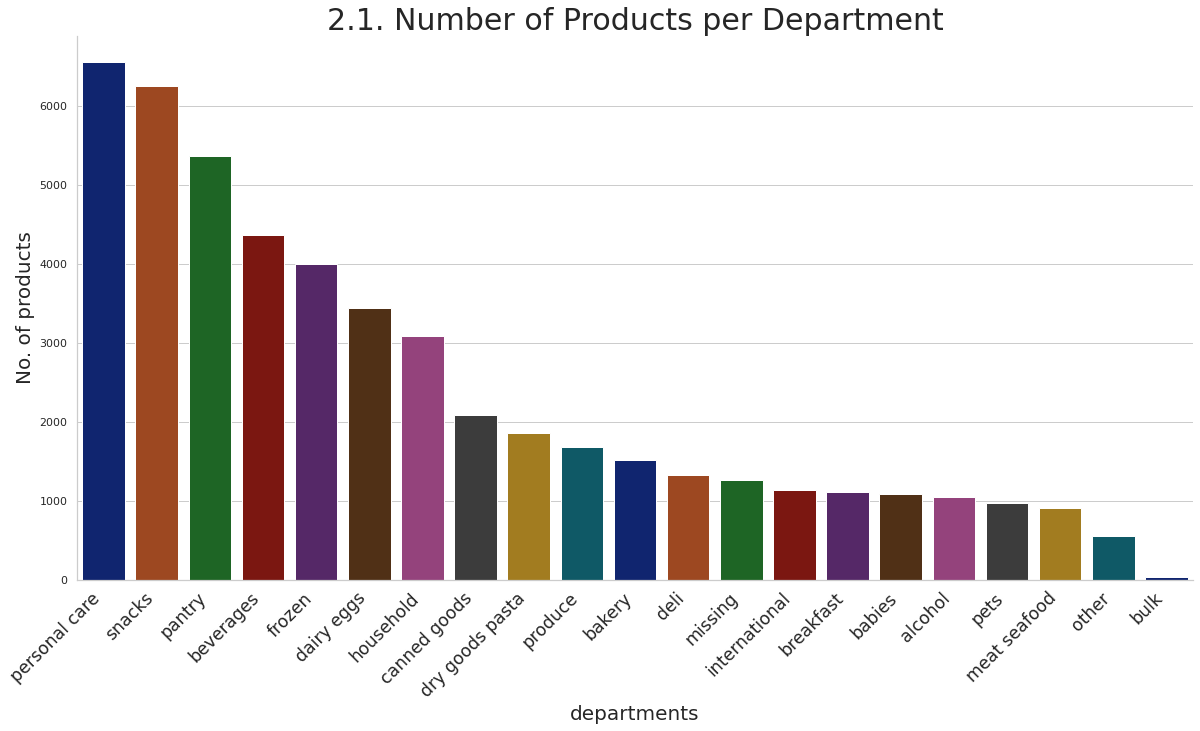

In [4]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
plot=sns.barplot(x='department',y='number_of_unique_products',data=number_of_unique_products_per_department,palette='dark')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('departments',size=20)
plt.ylabel('No. of products',size=20)
plt.title('2.1. Number of Products per Department',size=30)
sns.despine()
plt.show()

## ***2.2. How many products ordered from each department?***

In [5]:
%%time
query='''select table_2.department_id,table_3.department,count(table_1.product_id) as number_of_orders from order_products__prior table_1
join (select product_id,department_id from products) table_2 on table_1.product_id=table_2.product_id
join departments table_3 on table_2.department_id=table_3.department_id
group by table_2.department_id
order by number_of_orders desc
'''
number_of_orders_per_department=pd.read_sql_query(query,conn)

CPU times: user 1min 15s, sys: 1.87 s, total: 1min 17s
Wall time: 1min 48s


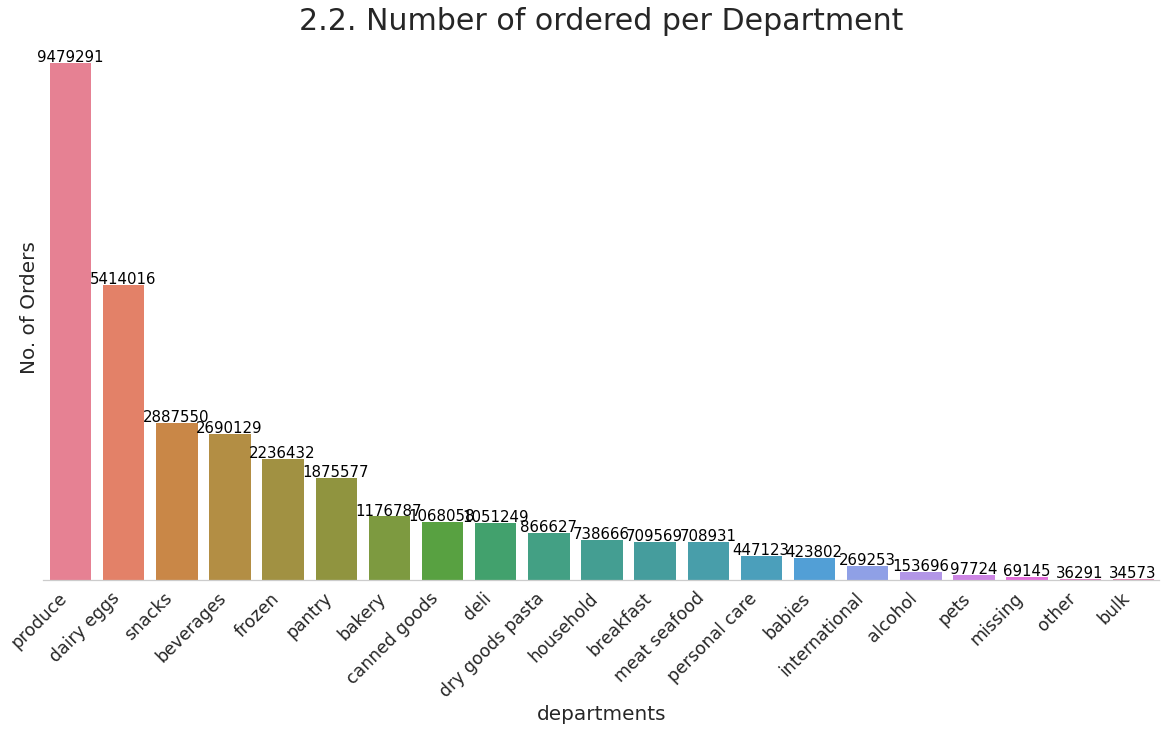

In [6]:
plt.figure(figsize=(20,10))
plot=sns.barplot(x='department',y='number_of_orders',data=number_of_orders_per_department,palette='husl')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('departments',size=20)
plt.ylabel('No. of Orders',size=20)
plt.yticks([], [])
plt.title('2.2. Number of ordered per Department',size=30)
for i,j in enumerate(number_of_orders_per_department.values):
    plt.text(x=i, y=j[2]+1, s=j[2], color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

## ***2.3. How many reorders from each department?***

In [7]:
%%time
query='''select table_2.department_id,table_3.department,(sum(table_1.reordered)*1.0/count(table_1.reordered)*1.0)*100 as percentage_of_reorders from order_products__prior table_1
join (select product_id,department_id from products) table_2 on table_1.product_id=table_2.product_id
join departments table_3 on table_2.department_id=table_3.department_id
group by table_2.department_id
order by percentage_of_reorders desc
'''
percentage_of_reorders_per_department=pd.read_sql_query(query,conn)

CPU times: user 1min 15s, sys: 1.31 s, total: 1min 17s
Wall time: 1min 34s


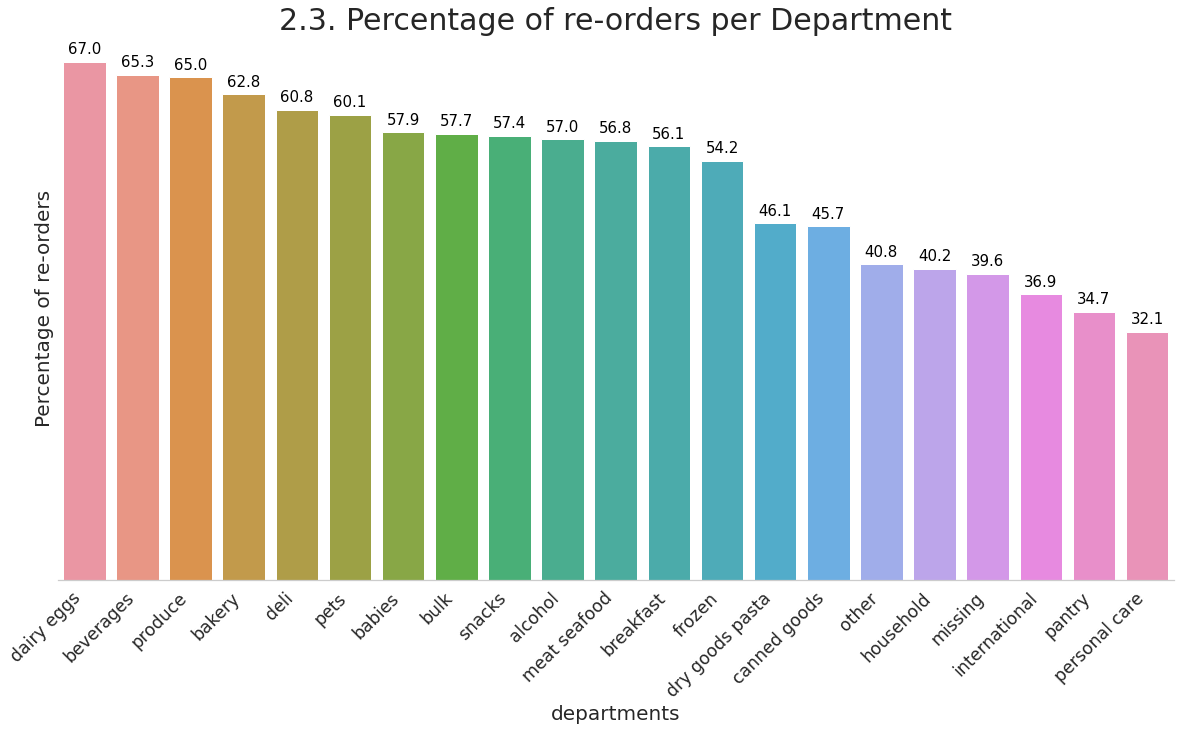

In [8]:
plt.figure(figsize=(20,10))
plot=sns.barplot(x='department',y='percentage_of_reorders',data=percentage_of_reorders_per_department)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('departments',size=20)
plt.ylabel('Percentage of re-orders',size=20)
plt.yticks([], [])
plt.title('2.3. Percentage of re-orders per Department',size=30)
for i,j in enumerate(percentage_of_reorders_per_department.values):
    plt.text(x=i, y=j[2]+1, s=round(j[2],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

### Plot-2.1,2.2,2.3: EDA on Departments
* *Personal care, Snacks, Pantry, Beverages, Frozen are top 5 departments whcih have highest number of unique products.*
* *But when coming to departments from which highest number of orders were placed, Produce and Dairy eggs stood tall. Personal care departments, which have highest number of unique products has less number of orders when compared to others. But top 2,3,4,5 among departments whcih have highest number of unique products showed considerable number of orders placed.*
* *Dairy eggs has more percentage of reorders than Produce which mean that Dairy eggs department has more number of products which are repurchased or reordered*
* *Reorders cannot be classified well with Departments as we can see in plot-2.3 that percentage of reorders is not so significantly different across the departments*


## ***2.4. What are the Days of week with most number of orders and reorders?***

In [9]:
%%time
query='''select order_dow,
count(distinct(order_id)) as c 
from orders
where eval_set='prior'
group by order_dow
'''
percentage_of_orders_by_day=pd.read_sql_query(query,conn)
percentage_of_orders_by_day['percentage_of_orders']=percentage_of_orders_by_day.c/percentage_of_orders_by_day.c.sum()
percentage_of_orders_by_day.drop('c',axis=1,inplace=True)

CPU times: user 8.46 s, sys: 1.91 s, total: 10.4 s
Wall time: 13.1 s


In [10]:
%%time
query='''select order_dow,count(*) as c from order_products__prior tab_1
join(select order_id,order_dow from orders) tab_2 on tab_1.order_id=tab_2.order_id
where reordered=1
group by order_dow
'''
percentage_of_reorders_by_day=pd.read_sql_query(query,conn)
percentage_of_reorders_by_day['percentage_of_reorders']=(percentage_of_reorders_by_day.c/percentage_of_reorders_by_day.c.sum())*100
percentage_of_reorders_by_day.drop('c',axis=1,inplace=True)

CPU times: user 34.2 s, sys: 11.8 s, total: 46 s
Wall time: 48.5 s


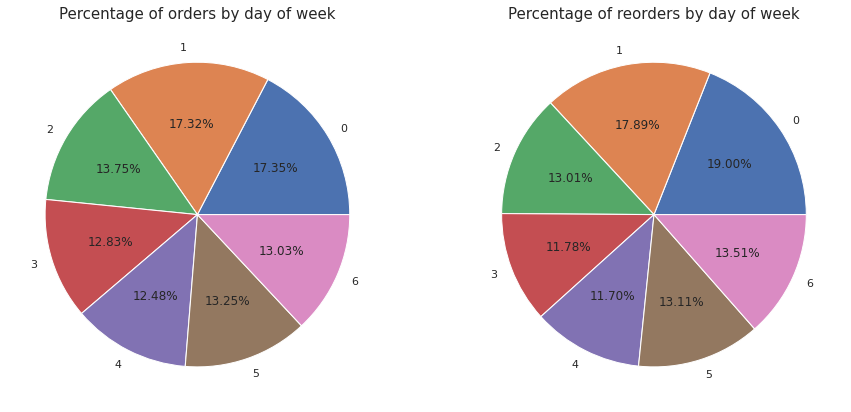

In [14]:
fig, axes = plt.subplots(1,2,figsize=(15,30), sharey=True)

axes[0].pie(x=percentage_of_orders_by_day.percentage_of_orders, autopct="%.2f%%", explode=[0.001]*7, labels=percentage_of_orders_by_day.order_dow.keys(), pctdistance=0.6)
axes[0].set_title('Percentage of orders by day of week',size=15)

axes[1].pie(x=percentage_of_reorders_by_day.percentage_of_reorders, autopct="%.2f%%", explode=[0.001]*7, labels=percentage_of_reorders_by_day.order_dow.keys(), pctdistance=0.6)
axes[1].set_title('Percentage of reorders by day of week',size=15)

plt.show()

## ***2.5. On which days of week Produce and Dairy Eggs products were ordered the most?***

In [15]:
%%time
query='''select order_dow,count(reordered) as c from order_products__prior table_1
join (select order_id,order_dow from orders) table_2 on table_1.order_id=table_2.order_id
join (select product_id,department_id from products 
where department_id=(select department_id from departments where lower(department)='produce')) table_3 on table_1.product_id=table_3.product_id
group by order_dow
'''
percentage_of_produce_by_dow=pd.read_sql_query(query,conn)
percentage_of_produce_by_dow['percentage_of_orders']=(percentage_of_produce_by_dow.c/percentage_of_produce_by_dow.c.sum())*100
percentage_of_produce_by_dow.drop('c',axis=1,inplace=True)

CPU times: user 2min 18s, sys: 2min 49s, total: 5min 8s
Wall time: 6min 7s


In [16]:
%%time
query='''select order_dow,count(reordered) as c from order_products__prior table_1
join (select order_id,order_dow from orders) table_2 on table_1.order_id=table_2.order_id
join (select product_id,department_id from products 
where department_id=(select department_id from departments where lower(department)='dairy eggs')) table_3 on table_1.product_id=table_3.product_id
group by order_dow
'''
percentage_of_dairyeggs_by_dow=pd.read_sql_query(query,conn)
percentage_of_dairyeggs_by_dow['percentage_of_orders']=(percentage_of_dairyeggs_by_dow.c/percentage_of_dairyeggs_by_dow.c.sum())*100
percentage_of_dairyeggs_by_dow.drop('c',axis=1,inplace=True)

CPU times: user 2min 10s, sys: 2min 48s, total: 4min 59s
Wall time: 5min 46s


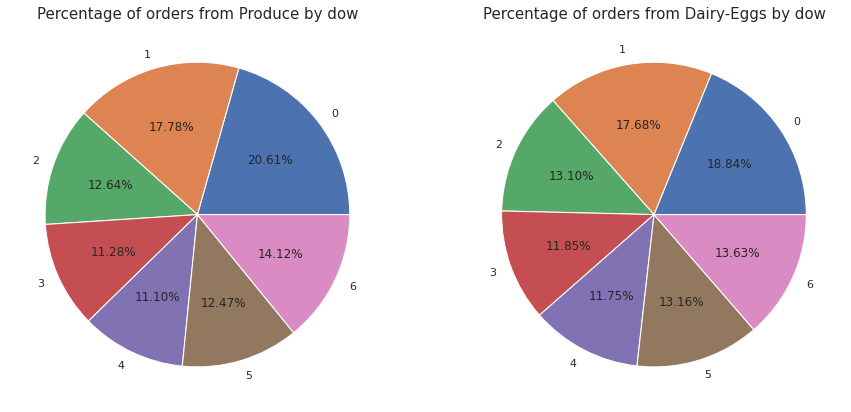

In [17]:
fig, axes = plt.subplots(1,2,figsize=(15,30), sharey=True)

axes[0].pie(x=percentage_of_produce_by_dow.percentage_of_orders, autopct="%.2f%%", explode=[0.001]*7, labels=percentage_of_produce_by_dow.order_dow.keys(), pctdistance=0.6)
axes[0].set_title('Percentage of orders from Produce by dow',size=15)

axes[1].pie(x=percentage_of_dairyeggs_by_dow.percentage_of_orders, autopct="%.2f%%", explode=[0.001]*7, labels=percentage_of_dairyeggs_by_dow.order_dow.keys(), pctdistance=0.6)
axes[1].set_title('Percentage of orders from Dairy-Eggs by dow',size=15)
plt.show()

## ***2.6. On what days of week products from meat seafood and alcohol departments were ordered the most?***

In [18]:
%%time
query='''select order_dow,count(reordered) as c from order_products__prior table_1
join (select order_id,order_dow from orders) table_2 on table_1.order_id=table_2.order_id
join (select product_id,department_id from products 
where department_id=(select department_id from departments where lower(department)='meat seafood')) table_3 on table_1.product_id=table_3.product_id
group by order_dow
'''
percentage_of_meat_orders_by_dow=pd.read_sql_query(query,conn)
percentage_of_meat_orders_by_dow['percentage_of_orders']=(percentage_of_meat_orders_by_dow.c/percentage_of_meat_orders_by_dow.c.sum())*100
percentage_of_meat_orders_by_dow.drop('c',axis=1,inplace=True)

CPU times: user 2min 6s, sys: 2min 46s, total: 4min 53s
Wall time: 5min 43s


In [19]:
%%time
query='''select order_dow,count(reordered) as c from order_products__prior table_1
join (select order_id,order_dow from orders) table_2 on table_1.order_id=table_2.order_id
join (select product_id,department_id from products 
where department_id=(select department_id from departments where lower(department)='alcohol')) table_3 on table_1.product_id=table_3.product_id
group by order_dow
'''
percentage_of_alcohol_orders_by_dow=pd.read_sql_query(query,conn)
percentage_of_alcohol_orders_by_dow['percentage_of_orders']=(percentage_of_alcohol_orders_by_dow.c/percentage_of_alcohol_orders_by_dow.c.sum())*100
percentage_of_alcohol_orders_by_dow.drop('c',axis=1,inplace=True)

CPU times: user 2min 4s, sys: 2min 45s, total: 4min 49s
Wall time: 5min 43s


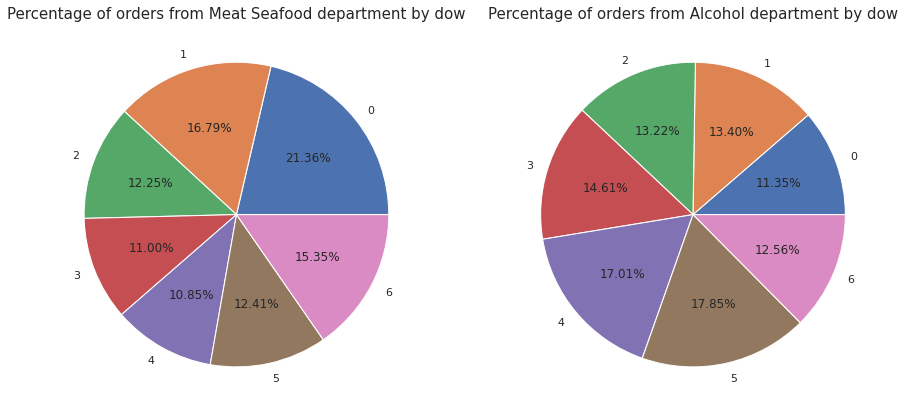

In [20]:
fig, axes = plt.subplots(1,2,figsize=(15,30), sharey=True)

axes[0].pie(x=percentage_of_meat_orders_by_dow.percentage_of_orders, autopct="%.2f%%", explode=[0.001]*7, labels=percentage_of_meat_orders_by_dow.order_dow.keys(), pctdistance=0.6)
axes[0].set_title('Percentage of orders from Meat Seafood department by dow',size=15)

axes[1].pie(x=percentage_of_alcohol_orders_by_dow.percentage_of_orders, autopct="%.2f%%", explode=[0.001]*7, labels=percentage_of_alcohol_orders_by_dow.order_dow.keys(), pctdistance=0.6)
axes[1].set_title('Percentage of orders from Alcohol department by dow',size=15)
plt.show()

### Plot-2.4,2.5,2.6: EDA on Day of week ordered
* *More number of orders and reorders were on day 0 and day 1 when compared to other days(plot-2.4)*
* *Reorders cannot classified with day of week ordered, day 0 and 1 have more number of reorders but it's because of more number of orders on those days of week*
* *Produce and Dairy eggs department products, which are ordered the most, were also ordered more on day 0 and day 1 when compared to other days of week(plot-2.5).*
* *Meat Seafood products were ordered most on Day 0 and 1. I checked this because in countries like India people consume Non-veg most on specific days of week like Sunday. I just wanted to check if there any cultural aspect exists in this data. We can observe that when compared with produce and dairy eggs, percentage of orders of meat seafood was more on day 0 and 6.*
* *Similarly Alcohol is consumed most on weekends globally. We can clearly observe that in plot-2.6 that Alcohol products were ordered most on day 4 and 5 in contrast with other departmets.*

## ***2.7. What are top-20 most Ordered products?***

In [21]:
%%time
query='''select table_1.product_id,table_2.product_name,table_3.department,count(*) as number_of_times_ordered from order_products__prior table_1
left join (select product_id,product_name,department_id from products) table_2 on table_1.product_id=table_2.product_id
left join departments table_3 on table_2.department_id=table_3.department_id
group by table_1.product_id
order by number_of_times_ordered desc
'''
top_20_most_ordered_products=pd.read_sql_query(query,conn).head(20)

CPU times: user 1min 28s, sys: 10 s, total: 1min 38s
Wall time: 1min 53s


In [22]:
top_20_most_ordered_products

,product_id,product_name,department,number_of_times_ordered
0,24852,Banana,produce,472565
1,13176,Bag of Organic Bananas,produce,379450
2,21137,Organic Strawberries,produce,264683
3,21903,Organic Baby Spinach,produce,241921
4,47209,Organic Hass Avocado,produce,213584
5,47766,Organic Avocado,produce,176815
6,47626,Large Lemon,produce,152657
7,16797,Strawberries,produce,142951
8,26209,Limes,produce,140627
9,27845,Organic Whole Milk,dairy eggs,137905


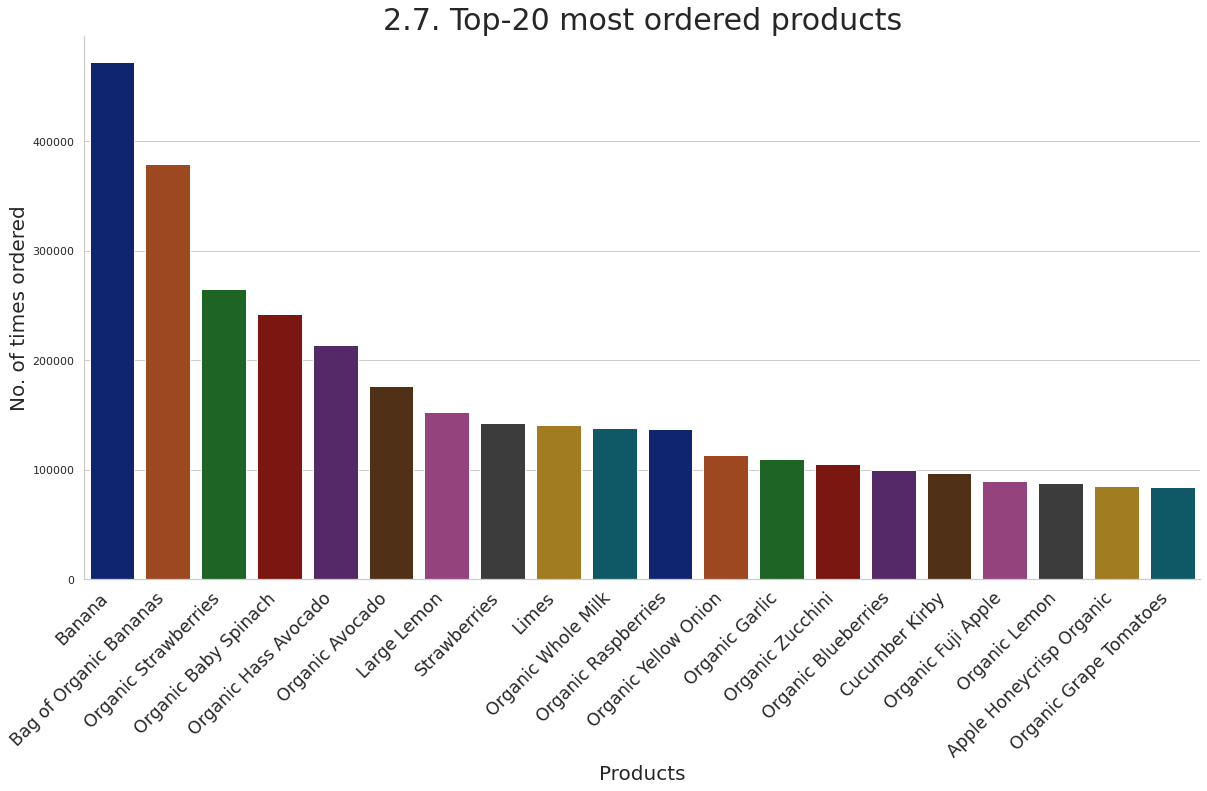

In [23]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
plot=sns.barplot(x='product_name',y='number_of_times_ordered',data=top_20_most_ordered_products,palette='dark')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('Products',size=20)
plt.ylabel('No. of times ordered',size=20)
plt.title('2.7. Top-20 most ordered products',size=30)
sns.despine()
plt.show()

## ***2.8. What are top-20 most reordered products?***

In [24]:
%%time
query='''select table_1.product_id,table_2.product_name,table_3.department,count(*) as number_of_times_reordered from order_products__prior table_1
left join (select product_id,product_name,department_id from products) table_2 on table_1.product_id=table_2.product_id
left join departments table_3 on table_2.department_id=table_3.department_id
where reordered=1
group by table_1.product_id
order by number_of_times_reordered desc
'''
top_20_most_reordered_products=pd.read_sql_query(query,conn).head(20)

CPU times: user 52.3 s, sys: 5.81 s, total: 58.2 s
Wall time: 1min 3s


In [25]:
top_20_most_reordered_products

,product_id,product_name,department,number_of_times_reordered
0,24852,Banana,produce,398609
1,13176,Bag of Organic Bananas,produce,315913
2,21137,Organic Strawberries,produce,205845
3,21903,Organic Baby Spinach,produce,186884
4,47209,Organic Hass Avocado,produce,170131
5,47766,Organic Avocado,produce,134044
6,27845,Organic Whole Milk,dairy eggs,114510
7,47626,Large Lemon,produce,106255
8,27966,Organic Raspberries,produce,105409
9,16797,Strawberries,produce,99802


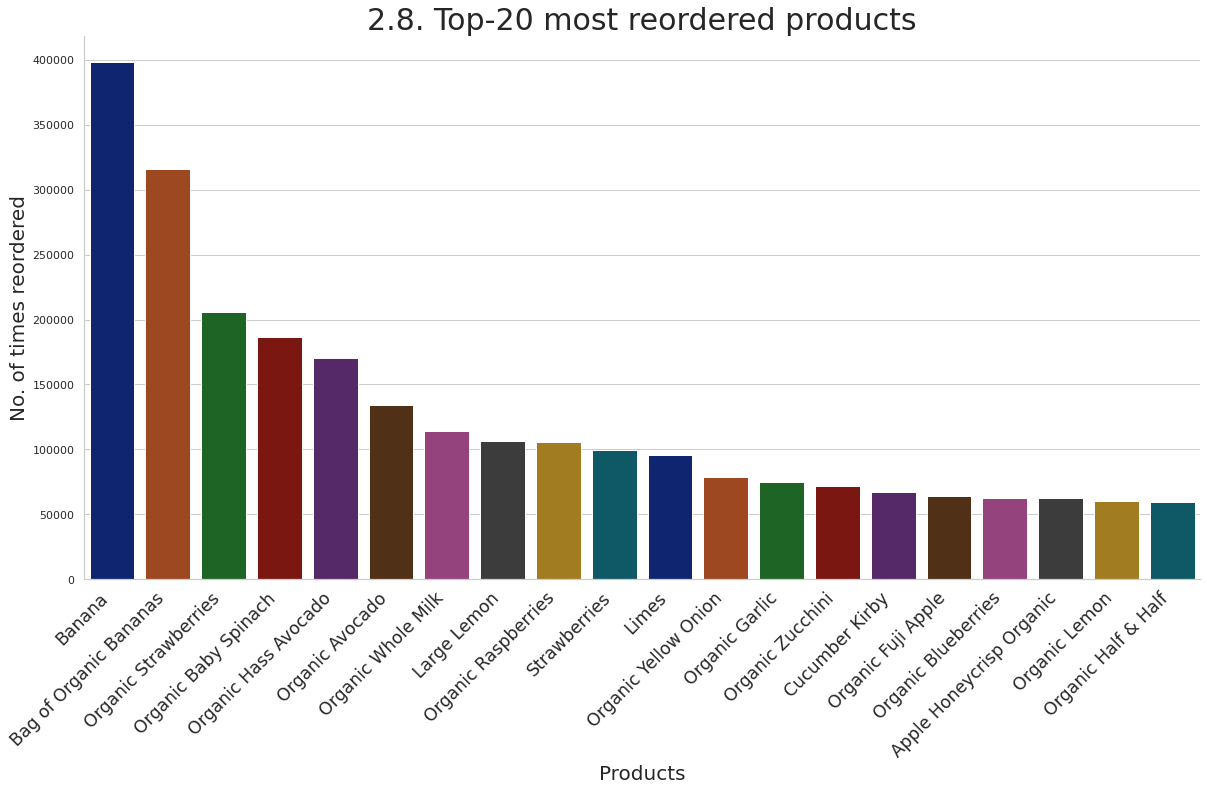

In [26]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
plot=sns.barplot(x='product_name',y='number_of_times_reordered',data=top_20_most_reordered_products,palette='dark')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('Products',size=20)
plt.ylabel('No. of times reordered',size=20)
plt.title('2.8. Top-20 most reordered products',size=30)
sns.despine()
plt.show()

### Plot-2.7,2.8: EDA on top most ordered and reordered Products
* *Fruits and Vegetables, especially Organic from Produce department were Ordered the most. Top-20 of most ordered products(plot-2.7) was completely dominated by Produce justifying plot-2.2.*
* *Coming Top-20 most reordered(plot-2.8), Produce showed dominance but Organic Whole Milk from Dairy Eggs department ramped up some places justifying plot-2.3 to some extent i.e., Dairy Eggs is the department from which most number of reorders took place.*


## ***2.9. Gaps between orders***

In [27]:
gaps_between_orders=pd.read_sql_query("select days_since_prior_order from orders where order_number!=1 and eval_set='prior'",conn)

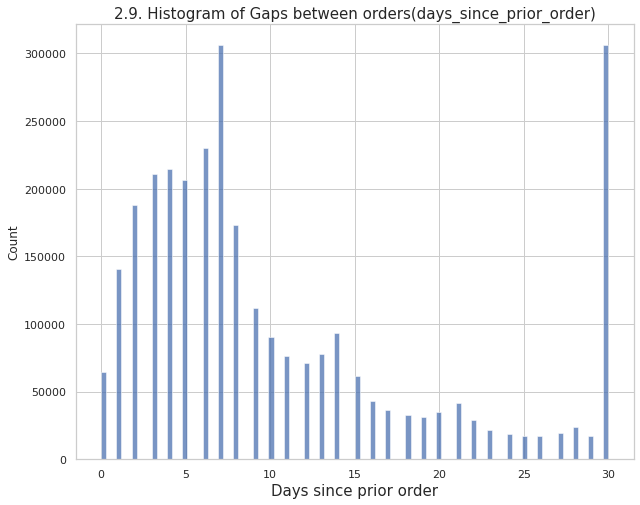

In [80]:
plt.figure(figsize=(10,8))
sns.histplot(gaps_between_orders.days_since_prior_order,binwidth=0.3)
plt.title('2.9. Histogram of Gaps between orders(days_since_prior_order)',size=15)
plt.xlabel('Days since prior order',size=15)
plt.show()

## ***2.10. Gaps between orders for order without reordered items***

In [82]:
%%time
query='''select tab_1.order_id,tab_2.days_since_prior_order from order_products__prior tab_1
join (select order_id,days_since_prior_order from orders where order_number>1) tab_2 on tab_1.order_id=tab_2.order_id
group by tab_1.order_id
having sum(reordered)=0
'''
orders_without_reorders=pd.read_sql_query(query,conn)

CPU times: user 1min 24s, sys: 10.5 s, total: 1min 34s
Wall time: 1min 51s


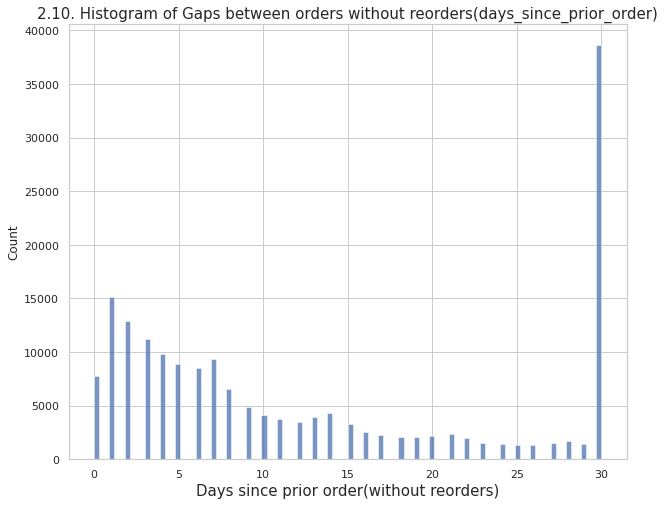

In [83]:
plt.figure(figsize=(10,8))
sns.histplot(orders_without_reorders.days_since_prior_order,binwidth=0.3)
plt.title('2.10. Histogram of Gaps between orders without reorders(days_since_prior_order)',size=15)
plt.xlabel('Days since prior order(without reorders)',size=15)
plt.show()

## ***2.11. Gaps between orders for order with reordered items***

In [84]:
%%time
query='''select tab_1.order_id,tab_2.days_since_prior_order from order_products__prior tab_1
join (select order_id,days_since_prior_order from orders where order_number>1) tab_2 on tab_1.order_id=tab_2.order_id
group by tab_1.order_id
having sum(reordered)>0
'''
orders_with_reorders=pd.read_sql_query(query,conn)

CPU times: user 1min 27s, sys: 11 s, total: 1min 38s
Wall time: 1min 53s


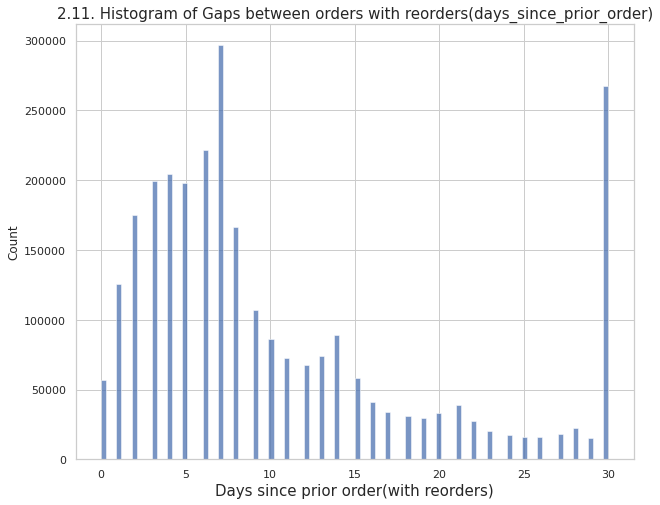

In [85]:
plt.figure(figsize=(10,8))
sns.histplot(orders_with_reorders.days_since_prior_order,binwidth=0.3)
plt.title('2.11. Histogram of Gaps between orders with reorders(days_since_prior_order)',size=15)
plt.xlabel('Days since prior order(with reorders)',size=15)
plt.show()

### Plot-2.9,2.10,2.11: EDA on Days since prior order
* *More numbers of orders were placed on same day(days_since_prior_order=0) than days_since_prior_order in 20-28 days range.*
* *We can observe from plot 2.10 and 2.11 that for orders without reorders we have more 30 days as days_since_prior_order than other. And in plot-2.11(Gaps with Reorders) we can observe that all gaps have equal significance with respect to their count(plot-2.8).*
* *Features based on days from prior order may classify data to an extent and we further explore it while feature engineering*


## ***2.12. How many orders have no reordered items?***

In [33]:
%%time
query='''select tab_1.order_id from order_products__prior tab_1
join (select order_id from orders where order_number>1) tab_2 on tab_1.order_id=tab_2.order_id
group by tab_1.order_id
having sum(reordered)=0
'''
orders_without_reorders=pd.read_sql_query(query,conn)

CPU times: user 1min 19s, sys: 10.3 s, total: 1min 29s
Wall time: 1min 45s


In [34]:
%%time
query='''select tab_1.order_id from order_products__prior tab_1
join (select order_id from orders where order_number>1) tab_2 on tab_1.order_id=tab_2.order_id
group by tab_1.order_id
having sum(reordered)>0
'''
orders_with_reorders=pd.read_sql_query(query,conn)

CPU times: user 1min 24s, sys: 10.5 s, total: 1min 34s
Wall time: 1min 50s


In [35]:
data=[['with out reorders',(orders_without_reorders.shape[0]/(orders_without_reorders.shape[0]+orders_with_reorders.shape[0]))*100],['with reorders',(orders_with_reorders.shape[0]/(orders_without_reorders.shape[0]+orders_with_reorders.shape[0]))*100]]
temp_df=pd.DataFrame(data,columns=['with/without','Percentage_of_orders'])
temp_df

,with/without,Percentage_of_orders
0,with out reorders,6.059299
1,with reorders,93.940701


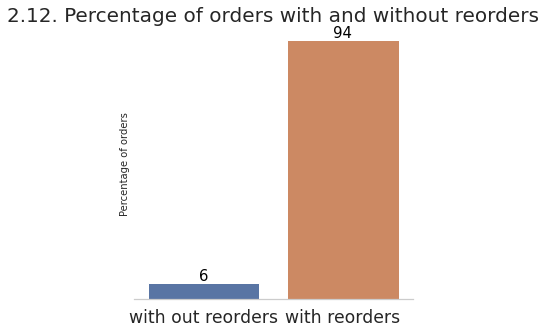

In [36]:
plt.figure(figsize=(5,5))
plot=sns.barplot(x='with/without',y='Percentage_of_orders',data=temp_df)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('')
plt.ylabel('Percentage of orders',size=10)
plt.yticks([], [])
plt.title('2.12. Percentage of orders with and without reorders',size=20)
for i,j in enumerate(temp_df.values):
    plt.text(x=i, y=j[1]+1, s=round(j[1]), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

### Plot-2.12
* *Orders without reordered products as very less*

## **2.13. Hour of the day**

In [37]:
%%time
query='''select order_hour_of_day,
count(distinct(order_id)) as c 
from orders
where eval_set='prior'
group by order_hour_of_day
'''
percentage_of_orders_by_hour=pd.read_sql_query(query,conn)
percentage_of_orders_by_hour['percentage_of_orders']=(percentage_of_orders_by_hour.c/percentage_of_orders_by_hour.c.sum())*100
percentage_of_orders_by_hour.drop('c',axis=1,inplace=True)

CPU times: user 6.71 s, sys: 171 ms, total: 6.88 s
Wall time: 7.52 s


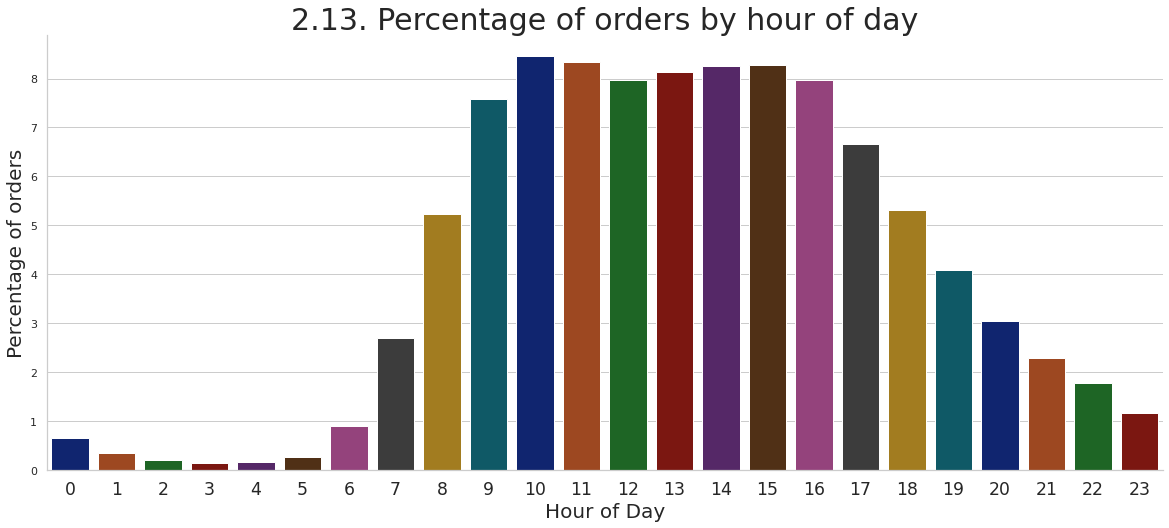

In [38]:
plt.figure(figsize=(20,8))
sns.set(style="whitegrid")
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_orders',data=percentage_of_orders_by_hour,palette='dark')
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of orders',size=20)
plt.title('2.13. Percentage of orders by hour of day',size=30)
sns.despine()
plt.show()

## ***2.14. Check on hour of day for None(order with only new products) orders.***

In [39]:
%%time
query='''select order_hour_of_day,count(distinct(order_id)) as c from (select tab_1.order_id,tab_2.order_hour_of_day from order_products__prior tab_1
join (select order_id,order_hour_of_day from orders where order_number>1) tab_2 on tab_1.order_id=tab_2.order_id
group by tab_1.order_id
having sum(reordered)=0)table_1
group by table_1.order_hour_of_day
'''
percentage_of_none_orders_by_HOD=pd.read_sql_query(query,conn)
percentage_of_none_orders_by_HOD['percentage_of_orders']=(percentage_of_none_orders_by_HOD.c/percentage_of_none_orders_by_HOD.c.sum())*100
percentage_of_none_orders_by_HOD.drop('c',axis=1,inplace=True)

CPU times: user 1min 22s, sys: 10.3 s, total: 1min 32s
Wall time: 1min 50s


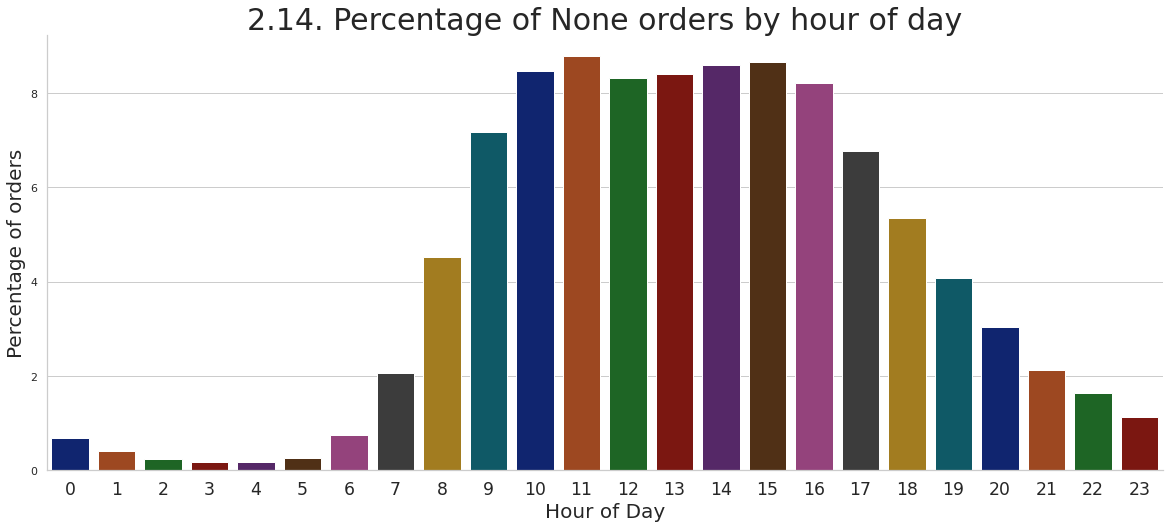

In [40]:
plt.figure(figsize=(20,8))
sns.set(style="whitegrid")
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_orders',data=percentage_of_none_orders_by_HOD,palette='dark')
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of orders',size=20)
plt.title('2.14. Percentage of None orders by hour of day',size=30)
sns.despine()
plt.show()

### Plot-2.13,2.14: EDA on Hour of Day ordered
* *We can observe that most number of orders were made day time(plot-2.13). There is no observe difference in this when concerned with Orders with all new products(plot-2.14)*

## ***2.15. Number of orders by users***

In [41]:
%%time
query='''select user_id,count(order_id) as number_of_orders from orders
where eval_set='prior'
group by user_id
'''
orders_by_users=pd.read_sql_query(query,conn)

CPU times: user 2.94 s, sys: 90 ms, total: 3.03 s
Wall time: 3.84 s


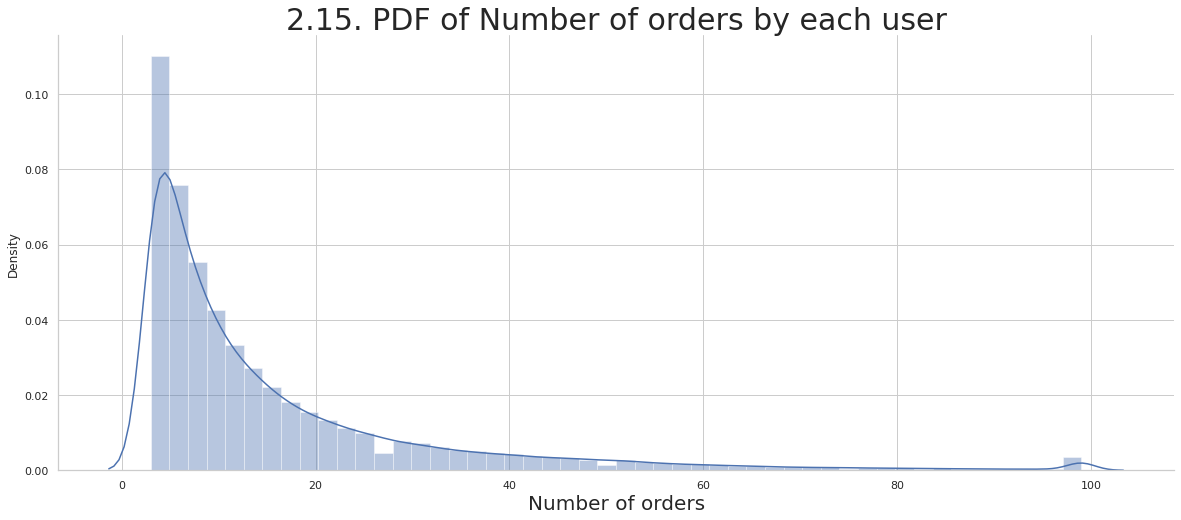

In [42]:
plt.figure(figsize=(20,8))
sns.set(style="whitegrid")
sns.distplot(orders_by_users['number_of_orders'])
plt.xlabel('Number of orders',size=20)
plt.title('2.15. PDF of Number of orders by each user',size=30)
sns.despine()
plt.show()

### ***Will above plot follow Power-Law Distribution?***

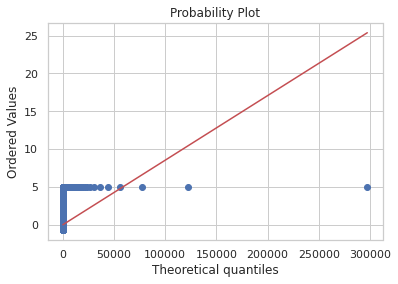

In [43]:
array=orders_by_users['number_of_orders']
standardized_array=(array-array.mean())/array.std()
scipy.stats.probplot(standardized_array,dist='pareto',sparams=(1,),plot=pylab)
pylab.show()

### ***Is the distribution Log-normal?***

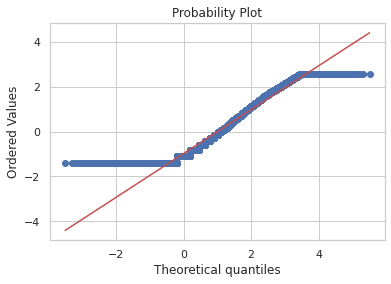

In [44]:
array=np.log(orders_by_users['number_of_orders'])
standardized_array=(array-array.mean())/array.std()
scipy.stats.probplot(standardized_array,dist='norm',sparams=(1,),plot=pylab)
pylab.show()

In [45]:
orders_by_users['number_of_orders'].describe()

count    206209.000000
mean         15.590367
std          16.654774
min           3.000000
25%           5.000000
50%           9.000000
75%          19.000000
max          99.000000
Name: number_of_orders, dtype: float64

In [46]:
number_of_orders=orders_by_users['number_of_orders']
for percentile in [80,85,90,95,96,97,99]:
    print('{} percentile: {}'.format(percentile,np.percentile(number_of_orders,percentile)))

80 percentile: 23.0
85 percentile: 28.0
90 percentile: 37.0
95 percentile: 51.0
96 percentile: 55.0
97 percentile: 61.0
99 percentile: 88.0


### Plot-2.15:
* *In the data we have, 3 is the minimum and 99 is the maximum number of prior orders by users.*
* *The distribution is right skewed and it does not follow Power-Law Distribution, and follows partial Log-Normal behavious for values greater than mean.*
* *Most of the users(more than 50%) placed not more than 10 orders.*
* *75% of users placed more than 5 orders.*
* *Only 5% of users ordered more than 50 orders.*


## ***2.16. Number of unique products ordered by users***

In [47]:
%%time
query='''select user_id,count(distinct(product_id)) as number_of_products from prior_user_product_combo
group by user_id
'''
number_of_unique_products_by_users=pd.read_sql_query(query,conn)

CPU times: user 32.1 s, sys: 1.4 s, total: 33.5 s
Wall time: 47.7 s


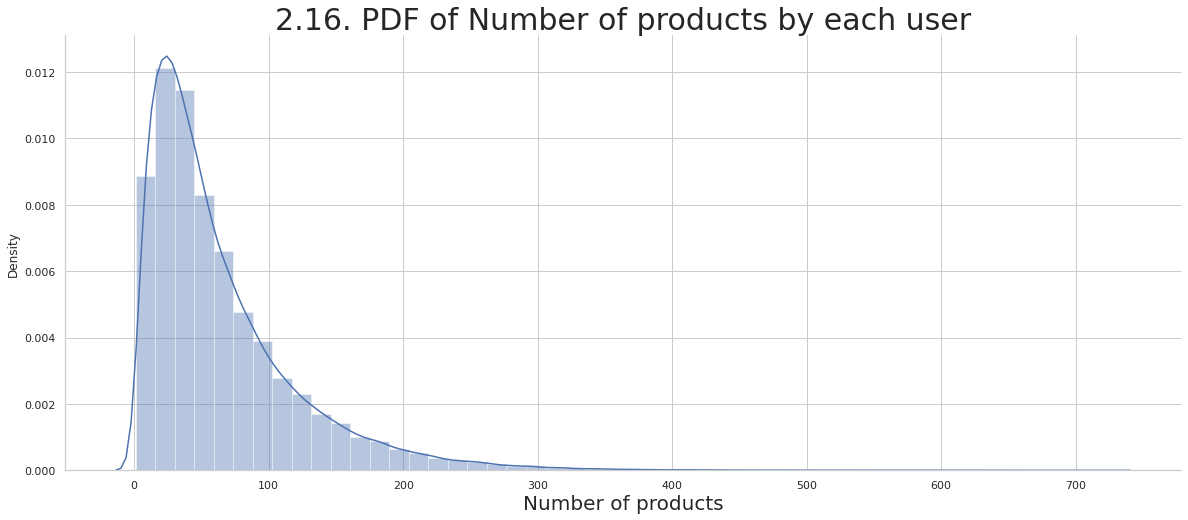

In [48]:
plt.figure(figsize=(20,8))
sns.set(style="whitegrid")
sns.distplot(number_of_unique_products_by_users['number_of_products'])
plt.xlabel('Number of products',size=20)
plt.title('2.16. PDF of Number of products by each user',size=30)
sns.despine()
plt.show()

### ***Is this distribution Log-Normal?***

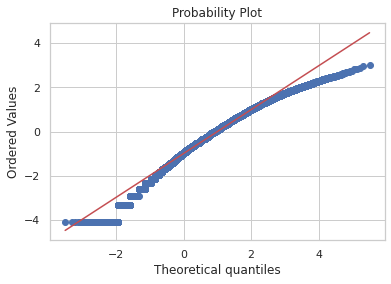

In [49]:
array=np.log(number_of_unique_products_by_users['number_of_products'])
standardized_array=(array-array.mean())/array.std()
scipy.stats.probplot(standardized_array,dist='norm',sparams=(1,),plot=pylab)
pylab.show()

In [50]:
number_of_unique_products_by_users['number_of_products'].describe()

count    206209.000000
mean         64.536238
std          56.592339
min           1.000000
25%          25.000000
50%          48.000000
75%          86.000000
max         726.000000
Name: number_of_products, dtype: float64

In [51]:
number_of_products=number_of_unique_products_by_users['number_of_products']
for percentile in [1,2,3,4,5]:
    print('{} percentile: {}'.format(percentile,np.percentile(number_of_products,percentile)))

1 percentile: 4.0
2 percentile: 5.0
3 percentile: 6.0
4 percentile: 7.0
5 percentile: 8.0


In [52]:
number_of_products=number_of_unique_products_by_users['number_of_products']
for percentile in [80,85,90,95,96,97,98,99]:
    print('{} percentile: {}'.format(percentile,np.percentile(number_of_products,percentile)))

80 percentile: 99.0
85 percentile: 115.0
90 percentile: 139.0
95 percentile: 179.0
96 percentile: 191.0
97 percentile: 207.0
98 percentile: 230.0
99 percentile: 266.0


### Plot-2.16:
* *50% of the users ordered around 50 unique products and 80% of users ordered less than 100 unique products*
* *Distribution is Right skewed and follows partial Log-Normal behaviour aroun the mean*

## ***2.17. Order size(no. of products in an order)***

In [53]:
%%time
query='''select order_id,count(*) as size_of_order from order_products__prior
group by order_id
'''
order_size=pd.read_sql_query(query,conn)

CPU times: user 31.3 s, sys: 875 ms, total: 32.2 s
Wall time: 37.1 s


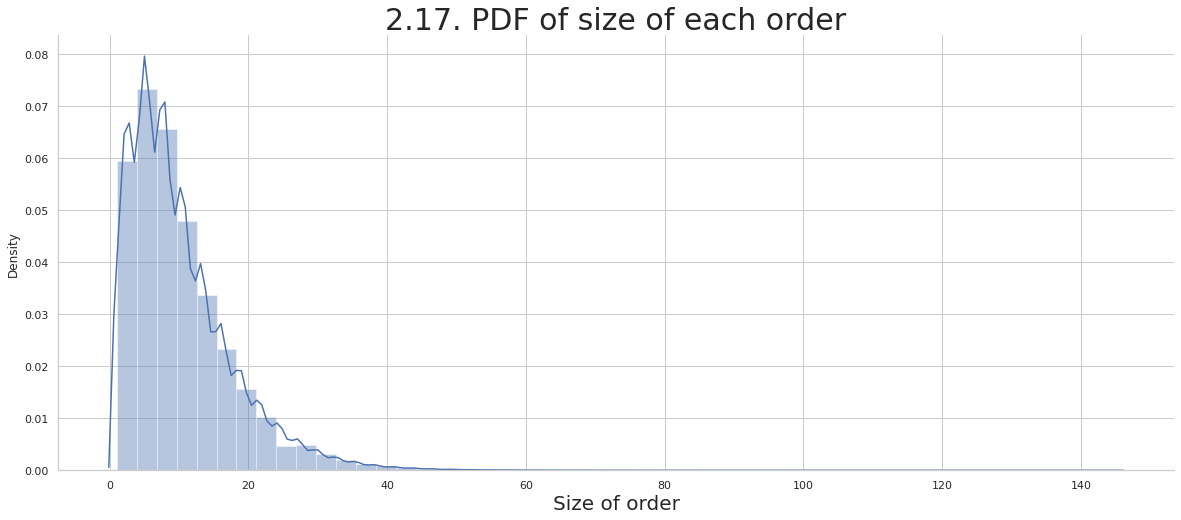

In [54]:
plt.figure(figsize=(20,8))
sns.set(style="whitegrid")
sns.distplot(order_size['size_of_order'])
plt.xlabel('Size of order',size=20)
plt.title('2.17. PDF of size of each order',size=30)
sns.despine()
plt.show()

In [55]:
order_size['size_of_order'].describe()

count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: size_of_order, dtype: float64

In [56]:
order_size=order_size['size_of_order']
for percentile in [80,85,90,95,96,97,98,99]:
    print('{} percentile: {}'.format(percentile,np.percentile(order_size,percentile)))

80 percentile: 15.0
85 percentile: 17.0
90 percentile: 20.0
95 percentile: 25.0
96 percentile: 26.0
97 percentile: 28.0
98 percentile: 31.0
99 percentile: 35.0


### Plot-2.17:
* *In 90% of orders, There are less than 21 products in cart.*
* *There are orders which contain very few products, if there are users who ordered more but number of unique products are less then it's more likely that user will reorder those products. This kind of behaviour can be captured by using number of orders,number of unique products ordered, average order size to-gether of a particular user.*


## ***2.18. Top-50 Aisles with most reordered percentage***

In [57]:
%%time
query='''select table_2.aisle_id,table_3.aisle,table_4.department,(sum(table_1.reordered)/(count(table_1.reordered)*1.0))*100 as percentage_of_reorders from order_products__prior table_1
join (select product_id,aisle_id,department_id from products) table_2 on table_1.product_id=table_2.product_id
join aisles table_3 on table_2.aisle_id=table_3.aisle_id
join departments table_4 on table_2.department_id=table_4.department_id
group by table_2.aisle_id
order by percentage_of_reorders desc
'''
percentage_of_reorders_per_aisle=pd.read_sql_query(query,conn).head(50)

CPU times: user 1min 31s, sys: 2.04 s, total: 1min 33s
Wall time: 1min 46s


In [58]:
percentage_of_reorders_per_aisle

,aisle_id,aisle,department,percentage_of_reorders
0,84,milk,dairy eggs,78.142792
1,115,water seltzer sparkling water,beverages,72.959349
2,24,fresh fruits,produce,71.810379
3,86,eggs,dairy eggs,70.536611
4,91,soy lactosefree,dairy eggs,69.255139
5,32,packaged produce,produce,69.073427
6,120,yogurt,dairy eggs,68.648935
7,53,cream,dairy eggs,68.504601
8,112,bread,bakery,67.016795
9,31,refrigerated,beverages,66.330197


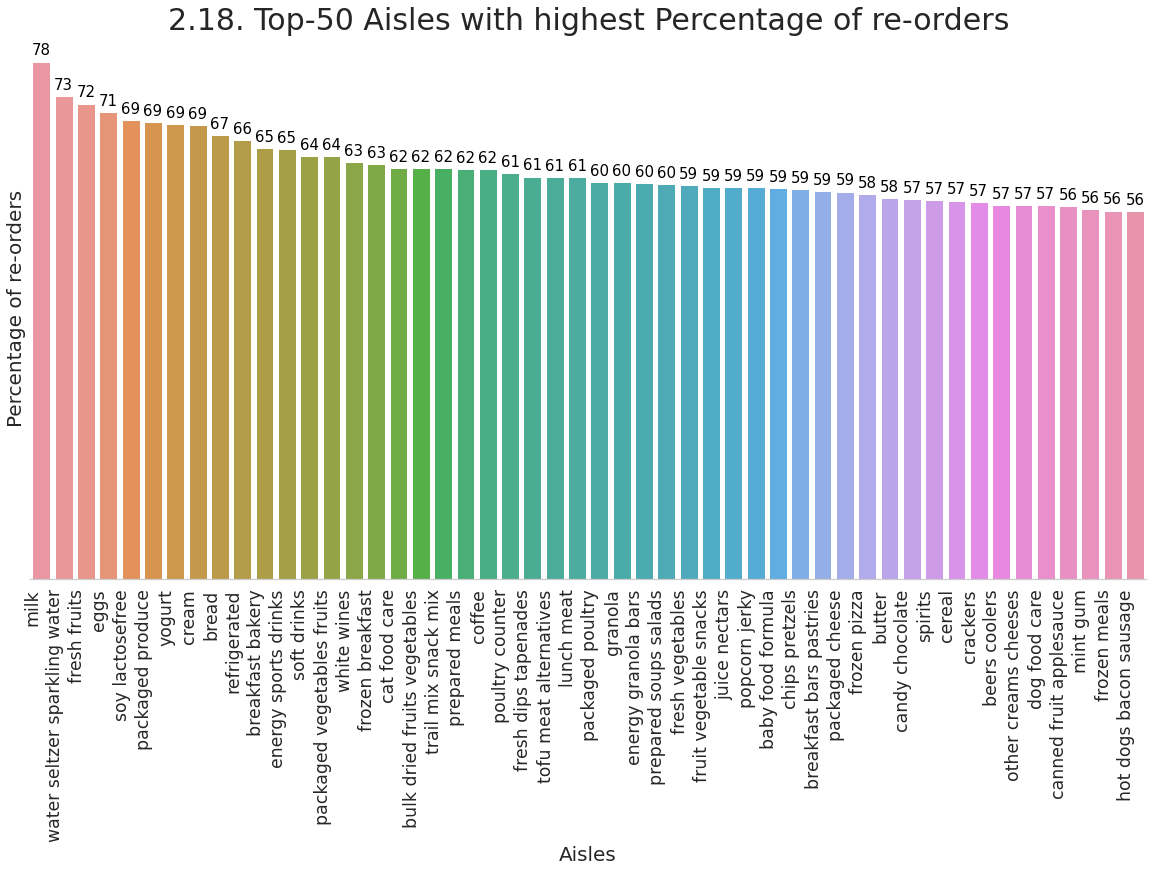

In [59]:
plt.figure(figsize=(20,10))
plot=sns.barplot(x='aisle',y='percentage_of_reorders',data=percentage_of_reorders_per_aisle)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('Aisles',size=20)
plt.ylabel('Percentage of re-orders',size=20)
plt.yticks([], [])
plt.title('2.18. Top-50 Aisles with highest Percentage of re-orders',size=30)
for i,j in enumerate(percentage_of_reorders_per_aisle.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3]), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

### Plot 2.18:
* *Dairy Eggs department Aisles are dominant in Top-10 most reordered aisles.*
* *Reordering cannot be clearly classified only with aisles as there are no aisles which showed significant difference.*


## ***2.19. Hour of day and Day of week combined***

*This analysis is on combination of Hour of day ordered and day of week ordered on specific departments which logically make sense. For example breakfast department products are mostly ordered in the mornings on every day of week and Alcohol department products are mostly ordered late in the evening on weekends. Now exploring on these departmennts is logically accepted.*

In [60]:
%%time
query='''select tab_4.department,tab_2.order_dow,tab_2.order_hour_of_day,(sum(reordered)*1.0/count(reordered)*1.0)*100 as percentage_of_reordered_products from order_products__prior tab_1
join (select order_id,order_dow,order_hour_of_day from orders) tab_2 on tab_1.order_id=tab_2.order_id
join (select product_id,department_id from products) tab_3 on tab_1.product_id=tab_3.product_id
join departments tab_4 on tab_3.department_id=tab_4.department_id
group by tab_3.department_id,tab_2.order_dow,tab_2.order_hour_of_day
'''
percentage_of_reorder_by_department_day_hour=pd.read_sql_query(query,conn)

CPU times: user 2min 32s, sys: 13.6 s, total: 2min 45s
Wall time: 3min 7s


### ***2.19.1. Breakfast department***

***Day-0***

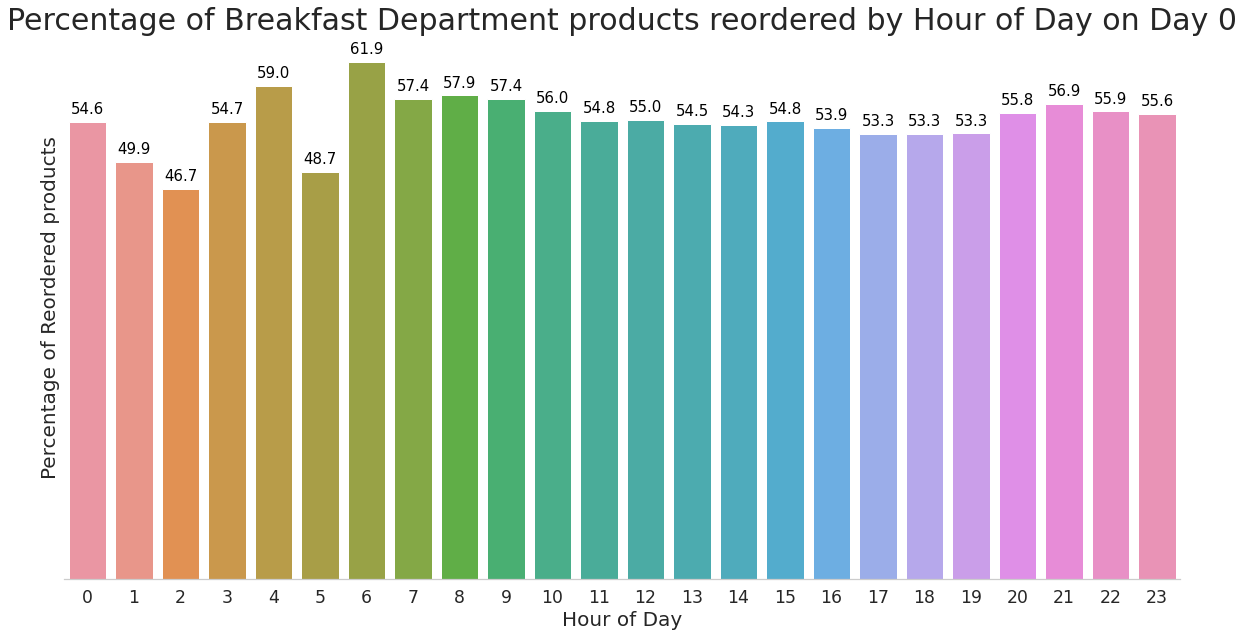

In [61]:
data=percentage_of_reorder_by_department_day_hour[(percentage_of_reorder_by_department_day_hour.department=='breakfast')&(percentage_of_reorder_by_department_day_hour.order_dow==0)]
plt.figure(figsize=(20,10))
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_reordered_products',data=data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of Reordered products',size=20)
plt.yticks([], [])
plt.title('Percentage of Breakfast Department products reordered by Hour of Day on Day 0',size=30)
for i,j in enumerate(data.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

***Day-1***

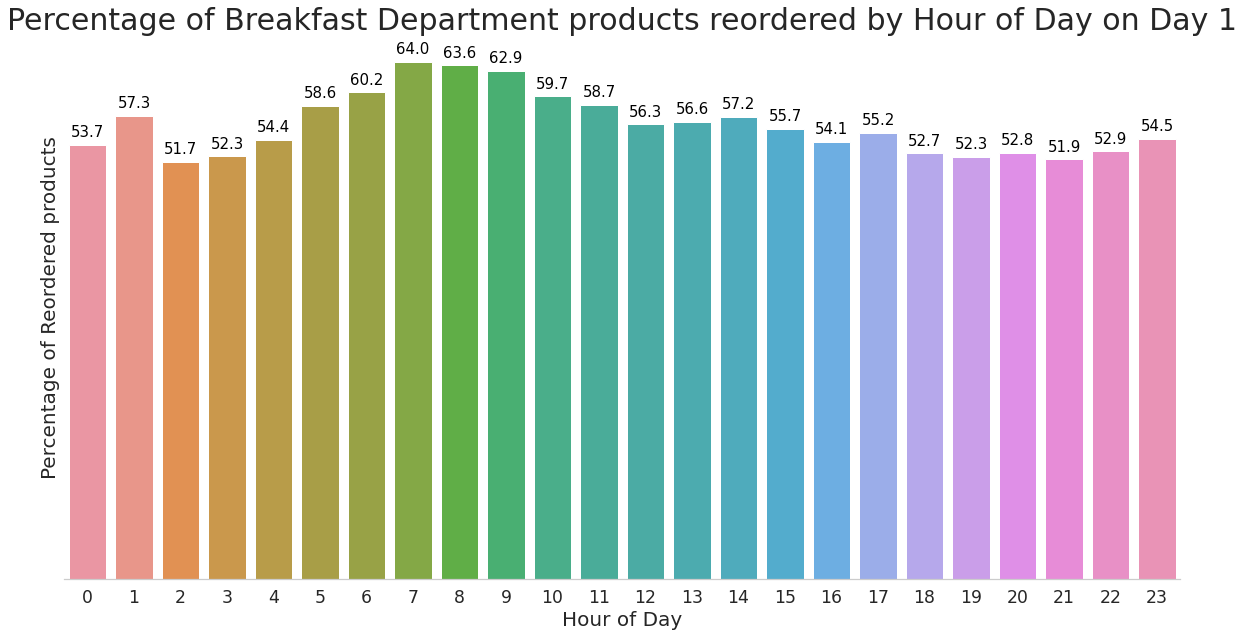

In [62]:
data=percentage_of_reorder_by_department_day_hour[(percentage_of_reorder_by_department_day_hour.department=='breakfast')&(percentage_of_reorder_by_department_day_hour.order_dow==1)]
plt.figure(figsize=(20,10))
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_reordered_products',data=data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of Reordered products',size=20)
plt.yticks([], [])
plt.title('Percentage of Breakfast Department products reordered by Hour of Day on Day 1',size=30)
for i,j in enumerate(data.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

***Day-5***

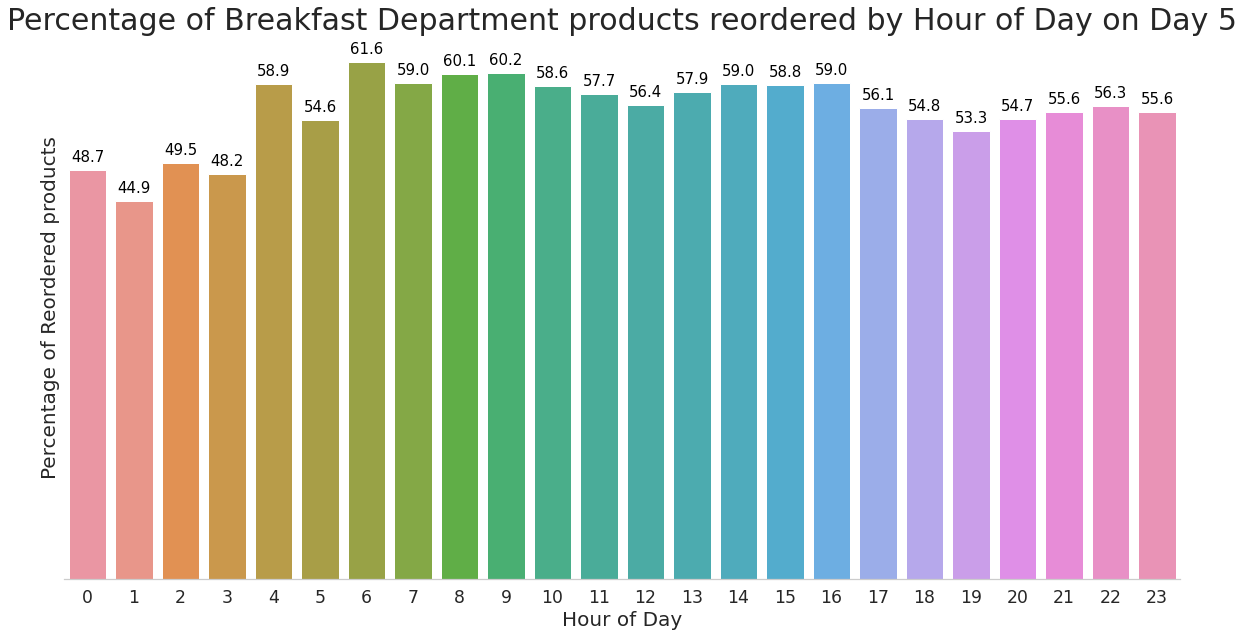

In [63]:
data=percentage_of_reorder_by_department_day_hour[(percentage_of_reorder_by_department_day_hour.department=='breakfast')&(percentage_of_reorder_by_department_day_hour.order_dow==5)]
plt.figure(figsize=(20,10))
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_reordered_products',data=data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of Reordered products',size=20)
plt.yticks([], [])
plt.title('Percentage of Breakfast Department products reordered by Hour of Day on Day 5',size=30)
for i,j in enumerate(data.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

***Day-6***

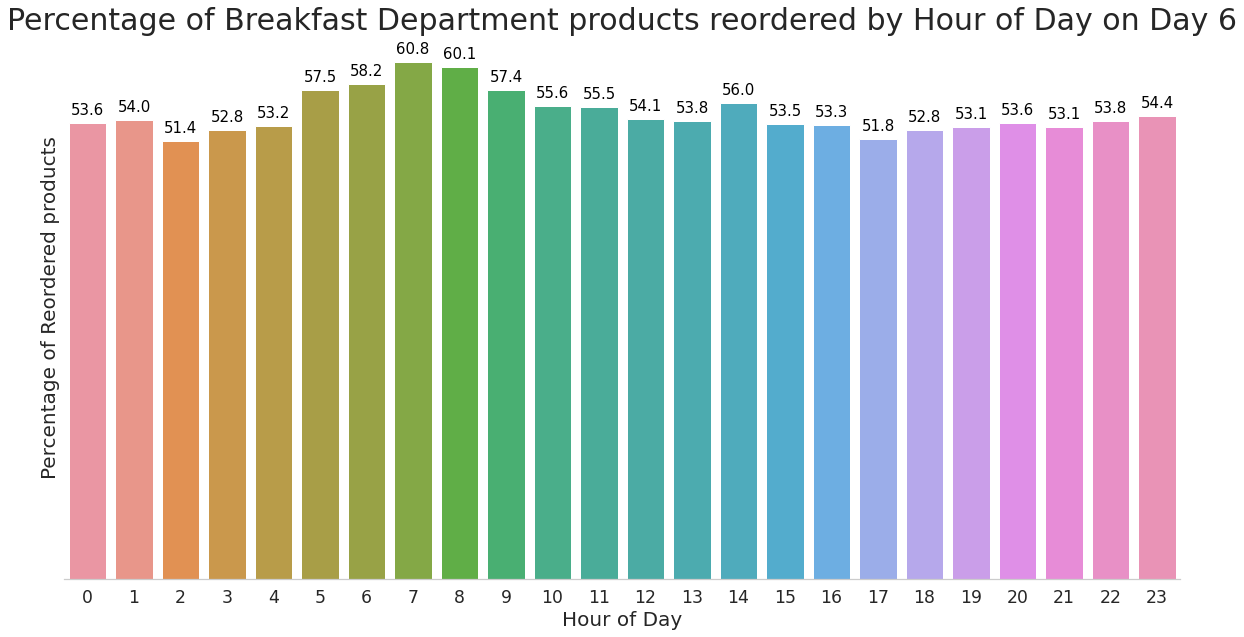

In [64]:
data=percentage_of_reorder_by_department_day_hour[(percentage_of_reorder_by_department_day_hour.department=='breakfast')&(percentage_of_reorder_by_department_day_hour.order_dow==6)]
plt.figure(figsize=(20,10))
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_reordered_products',data=data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of Reordered products',size=20)
plt.yticks([], [])
plt.title('Percentage of Breakfast Department products reordered by Hour of Day on Day 6',size=30)
for i,j in enumerate(data.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

### ***2.19.2. Alcohol Department***

***Day-0***

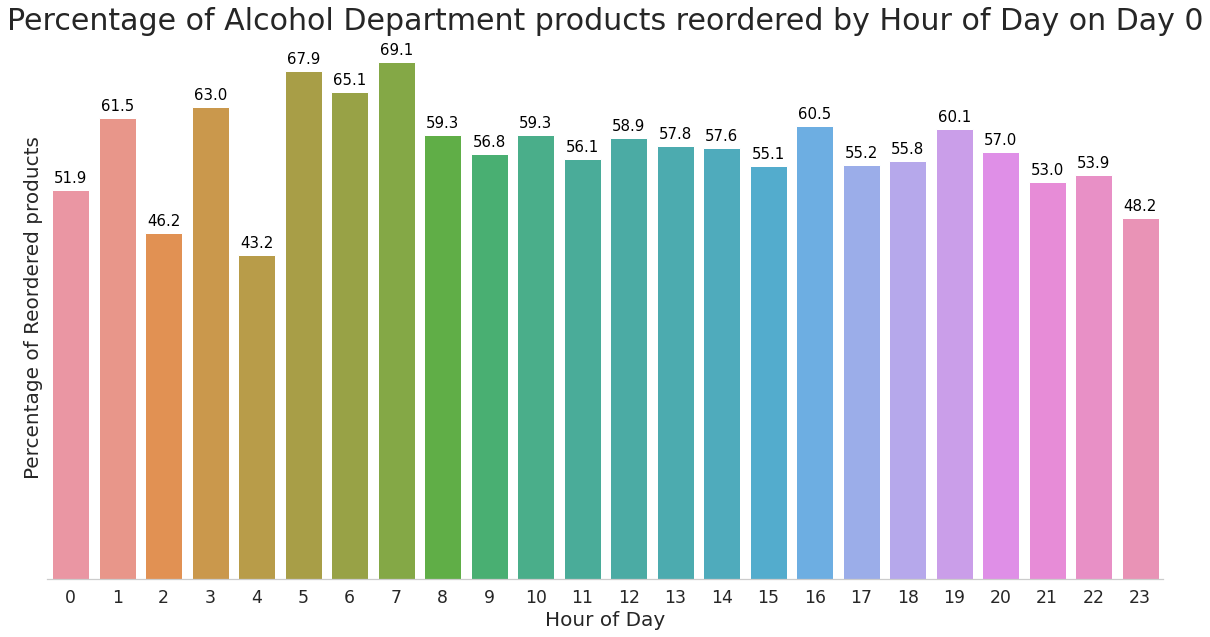

In [65]:
data=percentage_of_reorder_by_department_day_hour[(percentage_of_reorder_by_department_day_hour.department=='alcohol')&(percentage_of_reorder_by_department_day_hour.order_dow==0)]
plt.figure(figsize=(20,10))
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_reordered_products',data=data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of Reordered products',size=20)
plt.yticks([], [])
plt.title('Percentage of Alcohol Department products reordered by Hour of Day on Day 0',size=30)
for i,j in enumerate(data.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

***Day-1***

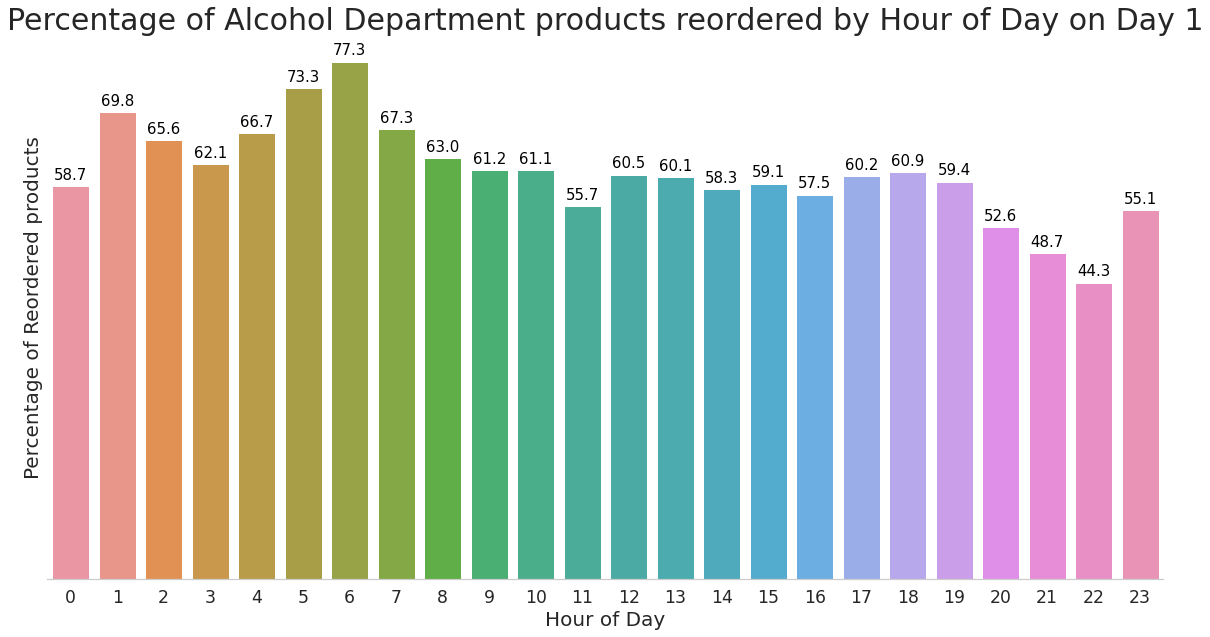

In [66]:
data=percentage_of_reorder_by_department_day_hour[(percentage_of_reorder_by_department_day_hour.department=='alcohol')&(percentage_of_reorder_by_department_day_hour.order_dow==1)]
plt.figure(figsize=(20,10))
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_reordered_products',data=data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of Reordered products',size=20)
plt.yticks([], [])
plt.title('Percentage of Alcohol Department products reordered by Hour of Day on Day 1',size=30)
for i,j in enumerate(data.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

***Day-2***

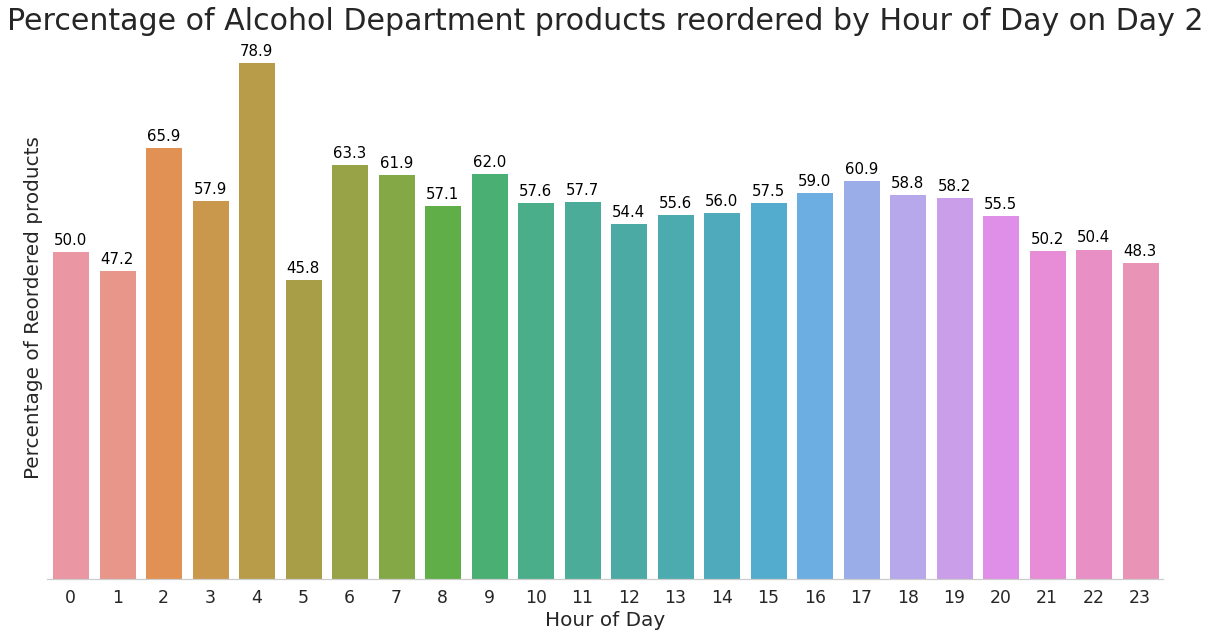

In [67]:
data=percentage_of_reorder_by_department_day_hour[(percentage_of_reorder_by_department_day_hour.department=='alcohol')&(percentage_of_reorder_by_department_day_hour.order_dow==2)]
plt.figure(figsize=(20,10))
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_reordered_products',data=data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of Reordered products',size=20)
plt.yticks([], [])
plt.title('Percentage of Alcohol Department products reordered by Hour of Day on Day 2',size=30)
for i,j in enumerate(data.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

***Day-3***

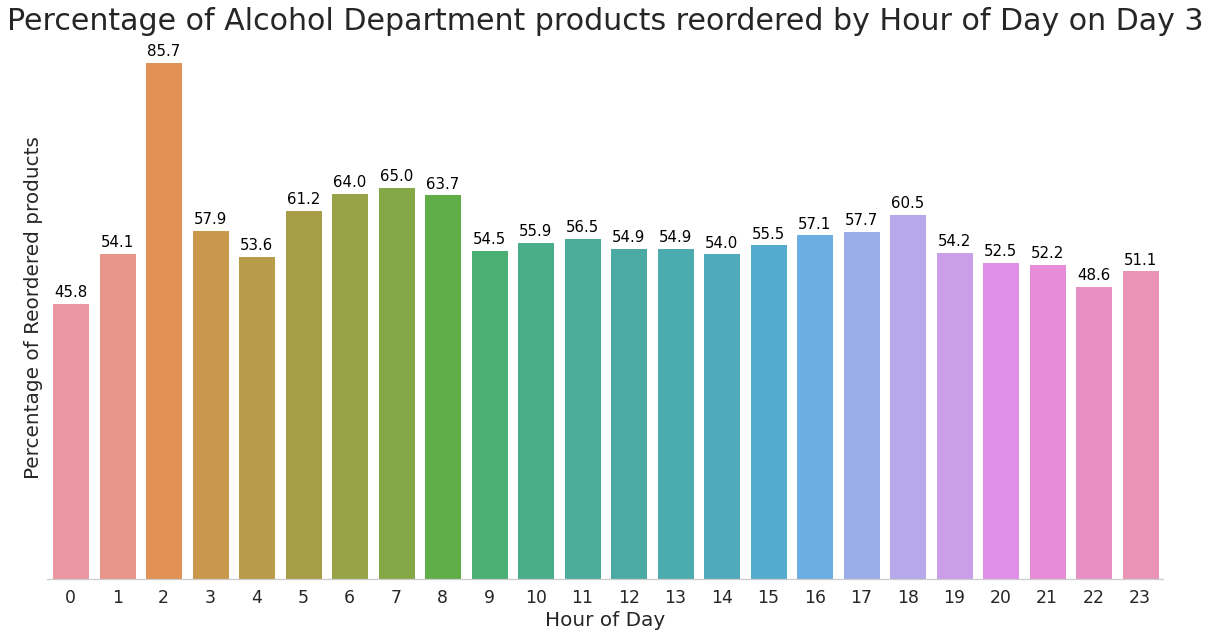

In [68]:
data=percentage_of_reorder_by_department_day_hour[(percentage_of_reorder_by_department_day_hour.department=='alcohol')&(percentage_of_reorder_by_department_day_hour.order_dow==3)]
plt.figure(figsize=(20,10))
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_reordered_products',data=data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of Reordered products',size=20)
plt.yticks([], [])
plt.title('Percentage of Alcohol Department products reordered by Hour of Day on Day 3',size=30)
for i,j in enumerate(data.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

***Day-4***

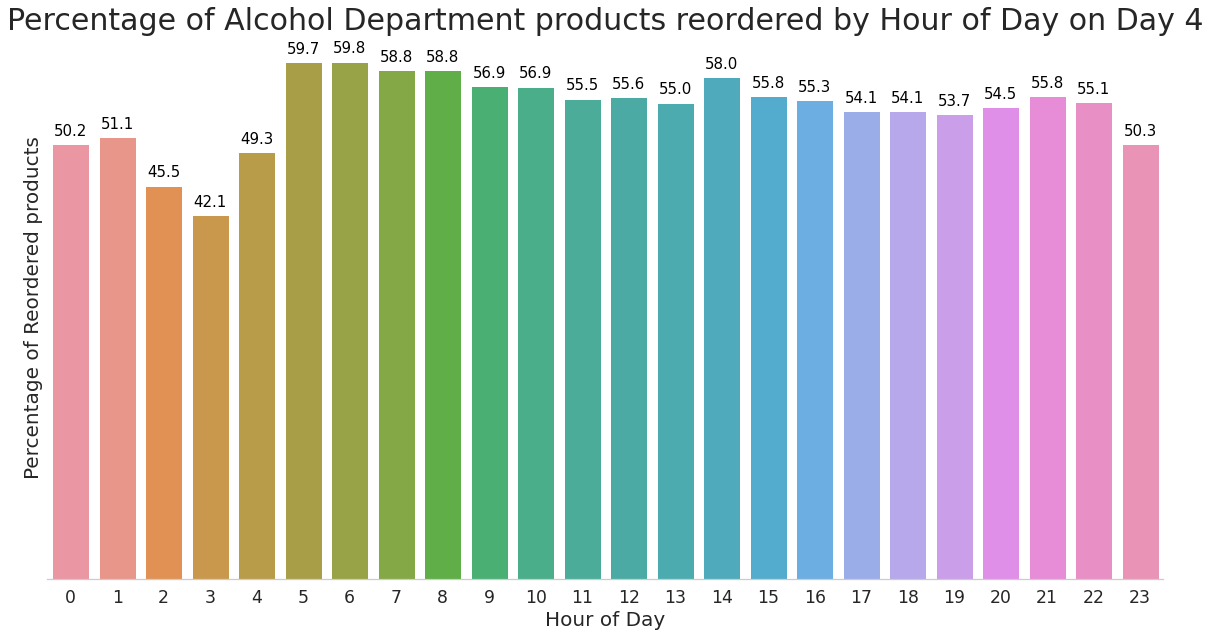

In [69]:
data=percentage_of_reorder_by_department_day_hour[(percentage_of_reorder_by_department_day_hour.department=='breakfast')&(percentage_of_reorder_by_department_day_hour.order_dow==4)]
plt.figure(figsize=(20,10))
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_reordered_products',data=data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of Reordered products',size=20)
plt.yticks([], [])
plt.title('Percentage of Alcohol Department products reordered by Hour of Day on Day 4',size=30)
for i,j in enumerate(data.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

***Day-5***

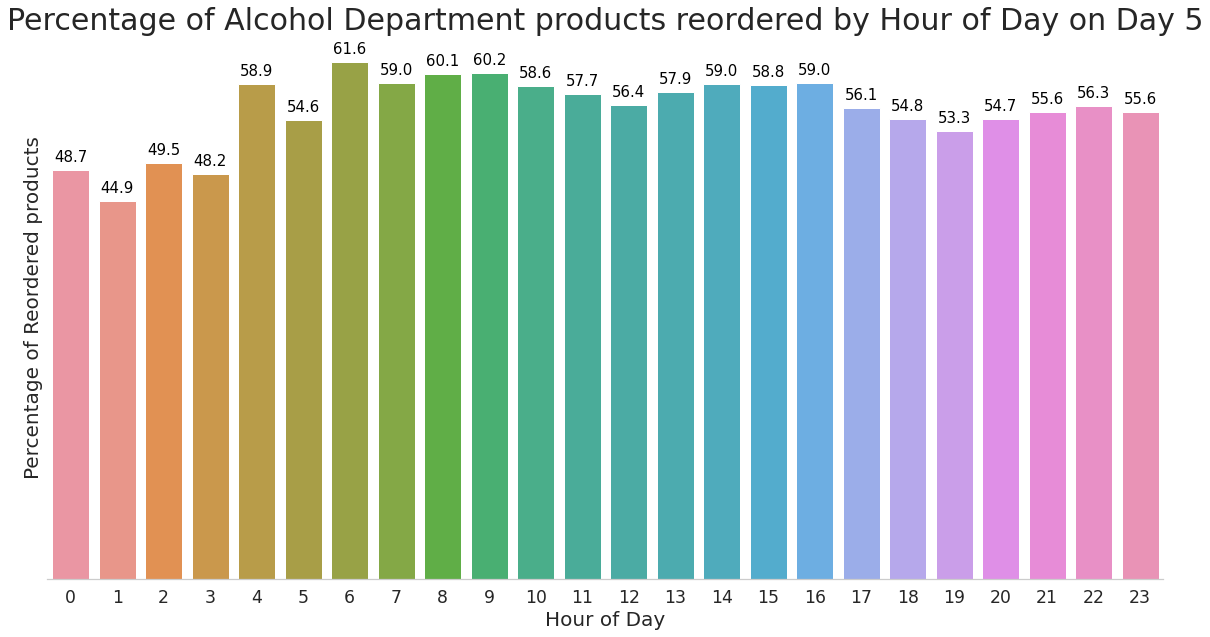

In [70]:
data=percentage_of_reorder_by_department_day_hour[(percentage_of_reorder_by_department_day_hour.department=='breakfast')&(percentage_of_reorder_by_department_day_hour.order_dow==5)]
plt.figure(figsize=(20,10))
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_reordered_products',data=data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of Reordered products',size=20)
plt.yticks([], [])
plt.title('Percentage of Alcohol Department products reordered by Hour of Day on Day 5',size=30)
for i,j in enumerate(data.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

***Day-6***

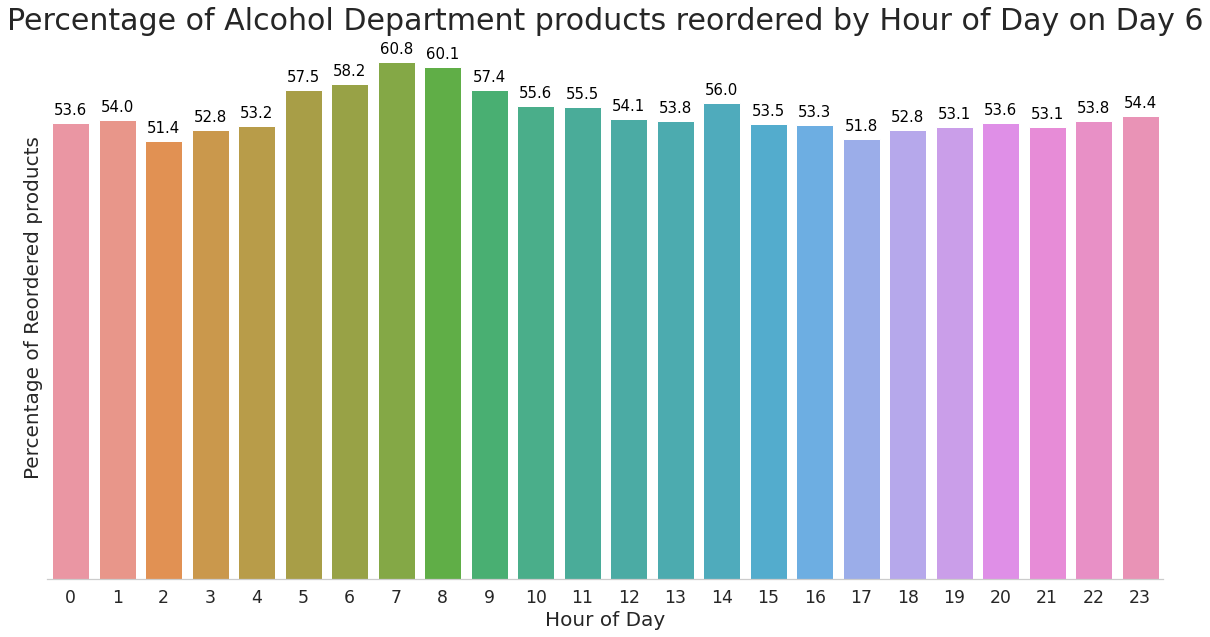

In [71]:
data=percentage_of_reorder_by_department_day_hour[(percentage_of_reorder_by_department_day_hour.department=='breakfast')&(percentage_of_reorder_by_department_day_hour.order_dow==6)]
plt.figure(figsize=(20,10))
plot=sns.barplot(x='order_hour_of_day',y='percentage_of_reordered_products',data=data)
plot.set_xticklabels(plot.get_xticklabels(), rotation=0, horizontalalignment='center',fontweight='light',fontsize='x-large')
plt.xlabel('Hour of Day',size=20)
plt.ylabel('Percentage of Reordered products',size=20)
plt.yticks([], [])
plt.title('Percentage of Alcohol Department products reordered by Hour of Day on Day 6',size=30)
for i,j in enumerate(data.values):
    plt.text(x=i, y=j[3]+1, s=round(j[3],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

### Plot(-s) -2.19:
* *Plots under 2.19.1 are for percentage of product reorders concerned with department table by Day of week and Hour of day. we can observe that Breakfast products reorder percentage was high in early morning times from 5 to 8 AM. Breakdfast products were ordered all over the day but it is obvious that most of them will be in mornings and reorderes were high in early morning times across all the days checked. The difference is not so significant but it gives an idea about the reorder pattern of Breakfast products.*


* *Coming to Alcohol department(under 2.19.2) we can clearly observe that at early times on weekdays the reordering percentage is high. You can observe that in days-0,1,2 and especially 3. From plot-2.6 we came to know that most number of Alcohol products are ordered on Day 4 an 5 but percentage of reordering on those is not so significantly classified and almost evenly spread across the day.*


* *From this we can say that Day of week and Hour of day have combined relationship when coming to reordering and it is different for each department. I did not analysed all the departments but analysed those two departments(Breakfast and Alcohol) which I felt as much classified by time of the day. But this relationship will exists for most of the departmemts.*

## ***2.20. Which Department products were ordered the most in None orders and with days_since_previous_orders as 30?***

*In plot-2.10 we can observe that None orders(orders with no reordered products) were ordered more on monthly basis i.e., the previous order by that user is 30 days back. Here I am checking which Department products were more on such kind of orders.*

In [72]:
%%time
query='''select table_4.department,count(table_1.product_id) as number_of_products from order_products__prior table_1
join (select tab_1.order_id from order_products__prior tab_1
join (select order_id,days_since_prior_order from orders where order_number>1) tab_2 on tab_1.order_id=tab_2.order_id
where tab_2.days_since_prior_order=30
group by tab_1.order_id
having sum(reordered)=0) table_2 on table_1.order_id=table_2.order_id
join products table_3 on table_1.product_id=table_3.product_id
join departments table_4 on table_3.department_id=table_4.department_id
group by table_3.department_id
order by number_of_products desc
'''
monthly_orders_without_reorders=pd.read_sql_query(query,conn)

CPU times: user 1min 31s, sys: 3.54 s, total: 1min 34s
Wall time: 1min 50s


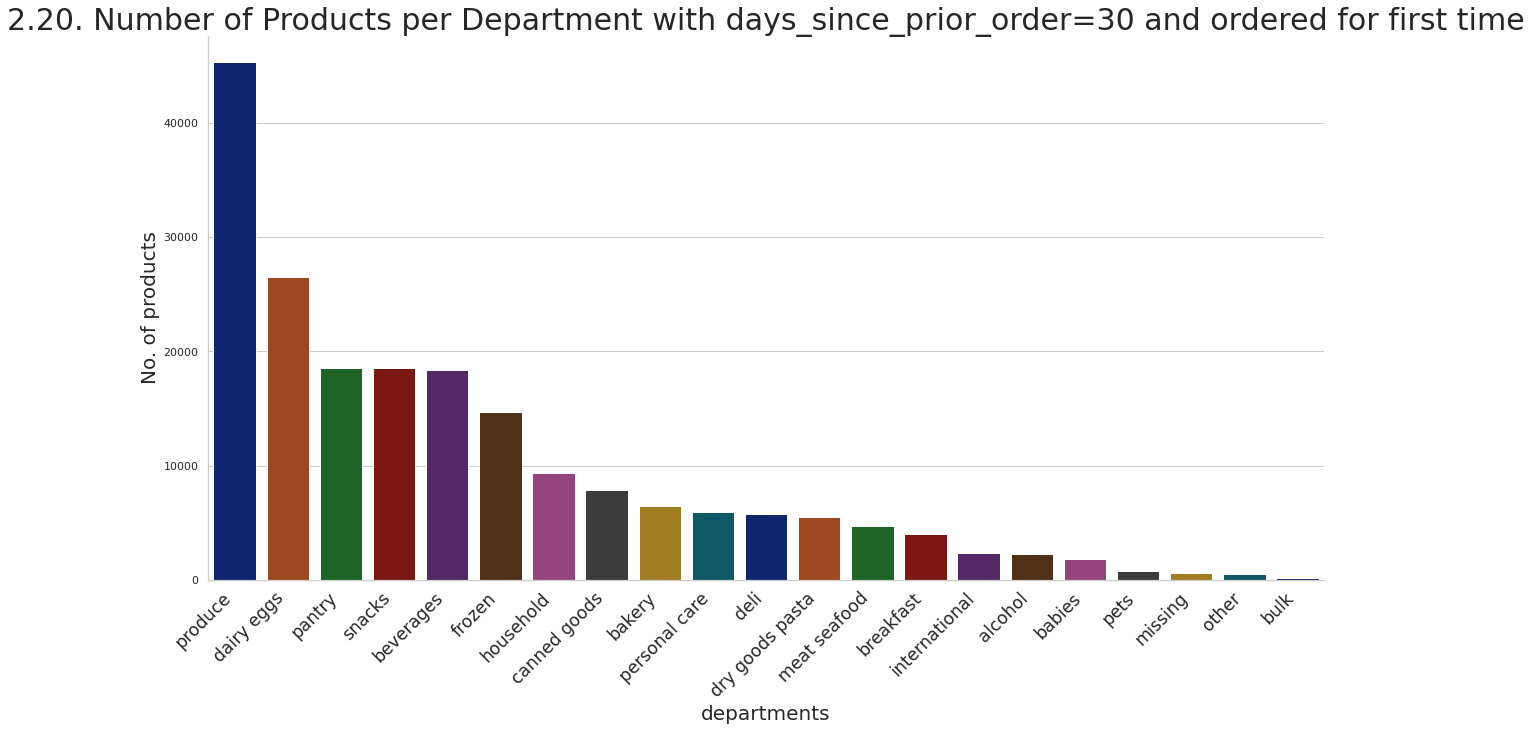

In [73]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
plot=sns.barplot(x='department',y='number_of_products',data=monthly_orders_without_reorders,palette='dark')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('departments',size=20)
plt.ylabel('No. of products',size=20)
plt.title('2.20. Number of Products per Department with days_since_prior_order=30 and ordered for first time',size=30)
sns.despine()
plt.show()

### Plot- 2.20:

* *In plot-2.10(Histogram of days_since_prior_order of None orders) we observed that highest number of such orders were placed on 30th day from previous order of user. I checked which Department products were most newly ordered in such None orders.*


* *Considering plot-2.2(Departments with most number of orders), here in plot-2.20 we can observe that standings of departments like pantry, household, personal care increased. Delving into human behaviour, we generally shop household, pantry and personal care products on a monthly basis and we call it as monthly grocery shopping. People generally do that after getting their monthly pay credited. Unlike food items household, pantry and personal care products will have more shelf life. And from this plot we can observe that more users tend to change may be brands of these products when they order them on monthly basis.*

## ***2.21. Which Department products were reordered the most in orders with reordered products and with days_since_previous_orders as 7 and 30(Peaks of plot-11)?***

In [74]:
%%time
query='''select table_2.department_id,table_3.department,(sum(table_1.reordered)*1.0/count(table_1.reordered)*1.0)*100 as percentage_of_reorders from order_products__prior table_1
join (select order_id from orders where days_since_prior_order=7) ord on table_1.order_id=ord.order_id
join (select product_id,department_id from products) table_2 on table_1.product_id=table_2.product_id
join departments table_3 on table_2.department_id=table_3.department_id
group by table_2.department_id
order by percentage_of_reorders desc
'''
percentage_of_reorders_per_department_weekly=pd.read_sql_query(query,conn)

CPU times: user 53.4 s, sys: 2.71 s, total: 56.2 s
Wall time: 1min 4s


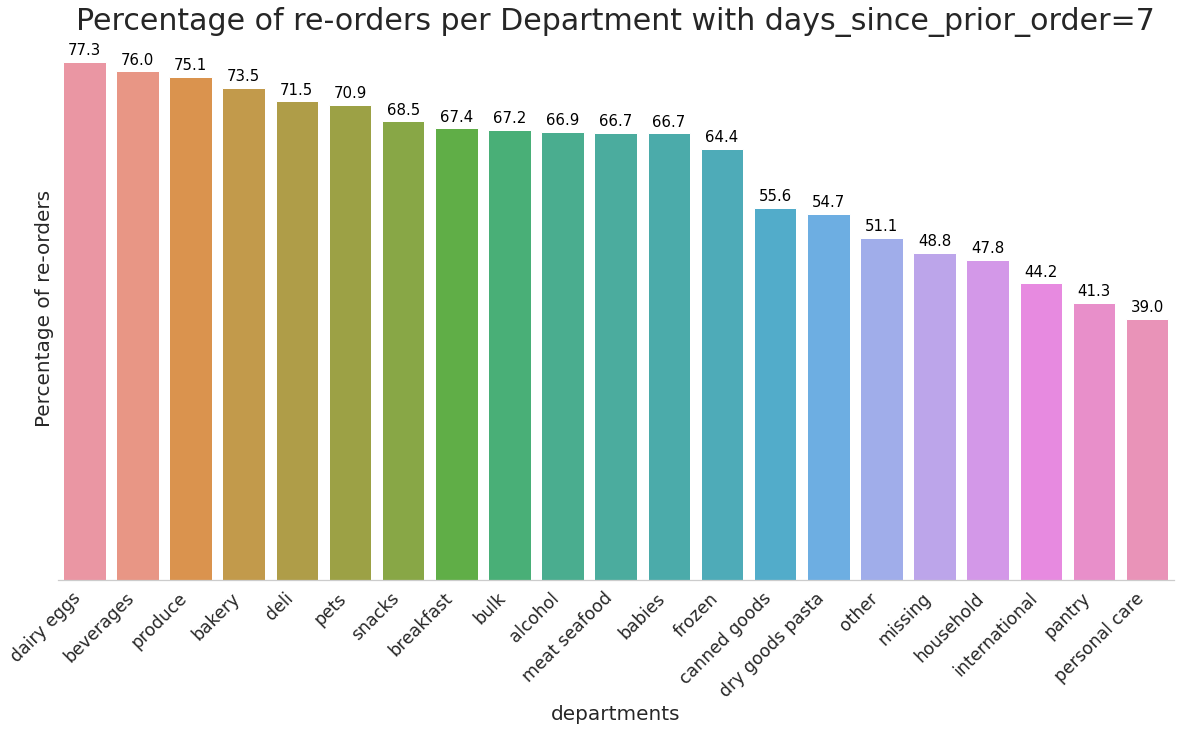

In [75]:
plt.figure(figsize=(20,10))
plot=sns.barplot(x='department',y='percentage_of_reorders',data=percentage_of_reorders_per_department_weekly)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('departments',size=20)
plt.ylabel('Percentage of re-orders',size=20)
plt.yticks([], [])
plt.title('Percentage of re-orders per Department with days_since_prior_order=7',size=30)
for i,j in enumerate(percentage_of_reorders_per_department_weekly.values):
    plt.text(x=i, y=j[2]+1, s=round(j[2],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

In [76]:
%%time
query='''select table_2.department_id,table_3.department,(sum(table_1.reordered)*1.0/count(table_1.reordered)*1.0)*100 as percentage_of_reorders from order_products__prior table_1
join (select order_id from orders where days_since_prior_order=30) ord on table_1.order_id=ord.order_id
join (select product_id,department_id from products) table_2 on table_1.product_id=table_2.product_id
join departments table_3 on table_2.department_id=table_3.department_id
group by table_2.department_id
order by percentage_of_reorders desc
'''
percentage_of_reorders_per_department_monthly=pd.read_sql_query(query,conn)

CPU times: user 54.8 s, sys: 2.71 s, total: 57.5 s
Wall time: 1min 6s


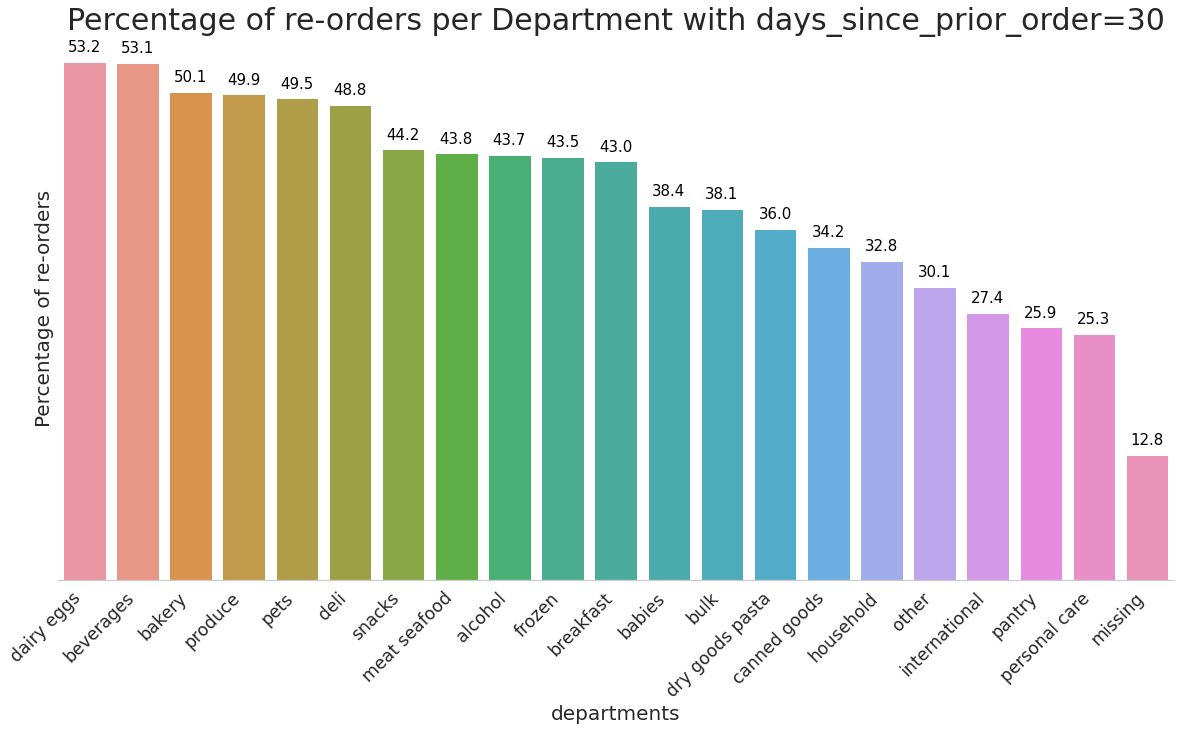

In [77]:
plt.figure(figsize=(20,10))
plot=sns.barplot(x='department',y='percentage_of_reorders',data=percentage_of_reorders_per_department_monthly)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('departments',size=20)
plt.ylabel('Percentage of re-orders',size=20)
plt.yticks([], [])
plt.title('Percentage of re-orders per Department with days_since_prior_order=30',size=30)
for i,j in enumerate(percentage_of_reorders_per_department_monthly.values):
    plt.text(x=i, y=j[2]+1, s=round(j[2],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

## ***2.22. Which Department products were newly ordered the most in orders with reordered products and with days_since_previous_orders as 7(weekly)?***

In [78]:
%%time
query='''select table_2.department_id,table_3.department,((count(table_1.reordered)-sum(table_1.reordered))*1.0/count(table_1.reordered)*1.0)*100 as percentage_of_reorders from order_products__prior table_1
join (select order_id from orders where days_since_prior_order=7) ord on table_1.order_id=ord.order_id
join (select product_id,department_id from products) table_2 on table_1.product_id=table_2.product_id
join departments table_3 on table_2.department_id=table_3.department_id
group by table_2.department_id
order by percentage_of_reorders desc
'''
percentage_of_new_orders_weekly=pd.read_sql_query(query,conn)

CPU times: user 54.6 s, sys: 2.46 s, total: 57.1 s
Wall time: 1min 6s


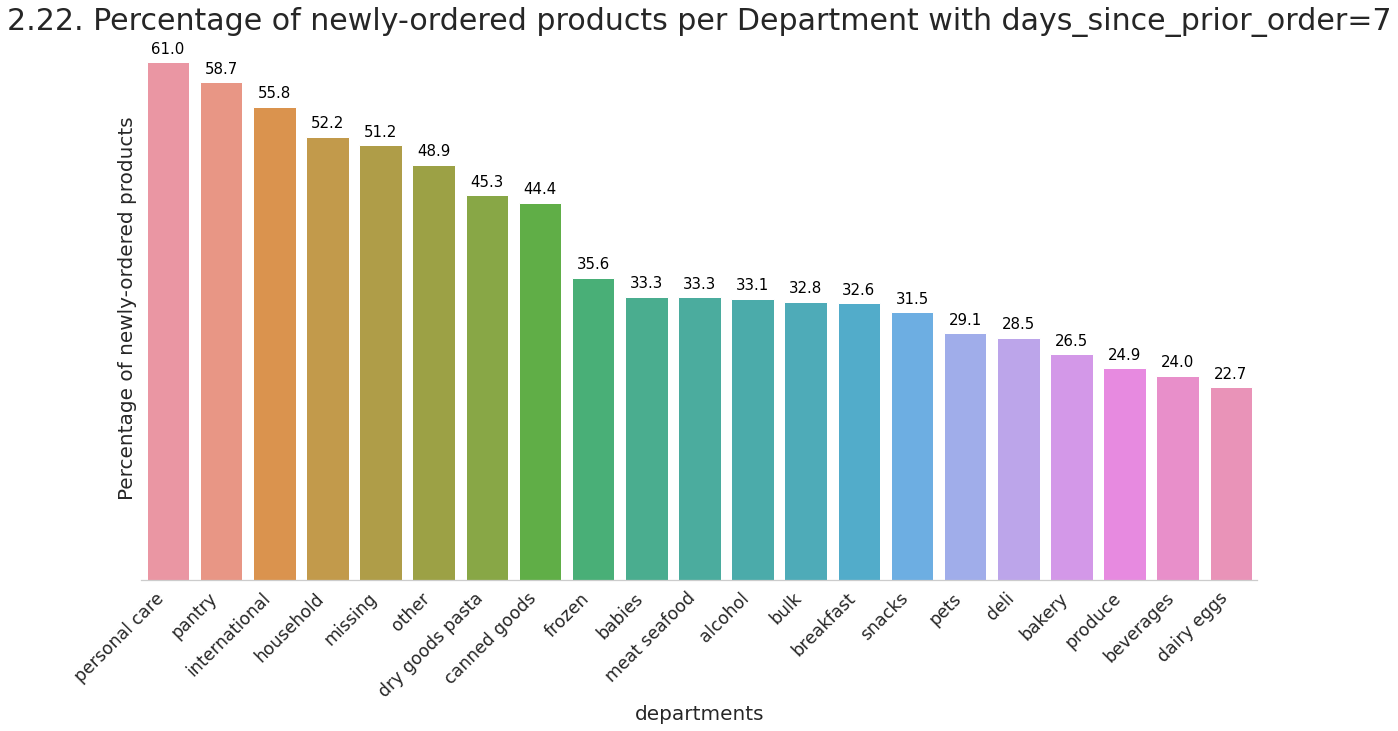

In [79]:
plt.figure(figsize=(20,10))
plot=sns.barplot(x='department',y='percentage_of_reorders',data=percentage_of_new_orders_weekly)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.xlabel('departments',size=20)
plt.ylabel('Percentage of newly-ordered products',size=20)
plt.yticks([], [])
plt.title('2.22. Percentage of newly-ordered products per Department with days_since_prior_order=7',size=30)
for i,j in enumerate(percentage_of_new_orders_weekly.values):
    plt.text(x=i, y=j[2]+1, s=round(j[2],1), color='black', fontsize=15, horizontalalignment='center',rotation=0)
sns.despine(left=True)
plt.show()

### Plot-2.21,2.22:
* *Plot(-s) 2.21 convey departments from which most of the products were reordered in orders with days_since_prior_order=7 and 30. Considering plot-2.3(percentage of reorders per department), standings in plot 2.21 didnot change much which convey that there can be no specific department-wise reordering pattern in orders with days_since_prior_order=7 and 30(weekly and monthly)*
* *Plot-2.22 is about department-wise percentage of newly ordered products in orders with days_since_prior_order=7, as observed earlier people tend to order new products from products which have larger shelf life like personal care products, pantry, household products etc.,*